In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import xgboost
import shap
from scipy.stats import chi2_contingency
import re
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from sklearn.decomposition import PCA
from scipy.stats import kruskal
import math
from sklearn.metrics import silhouette_score, silhouette_samples
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import rpy2.robjects as robjects
from rpy2.robjects import r,pandas2ri
from rpy2.robjects.packages import importr

def spectral_clustering_nSNN(A, k):
    data_size = A.shape[0]
    B = np.zeros((data_size, data_size))  # Create a similarity matrix which is fully connected

    # Compute similarity matrix using Gaussian function
    for i in range(data_size):
        for j in range(data_size):
            B[i, j] = np.exp(-np.sum((A[i, :] - A[j, :]) ** 2) / (2 * 1.5 ** 2))
            B[j, i] = B[i, j]

    temp = np.array([sorted(row, reverse=True) for row in B])  # Recording the distance in B from big to small
    I = np.argsort(-B, axis=1)  # I is the corresponding id

    for i in range(k, data_size):
        temp[:, i] = 0

    E = np.zeros((data_size, data_size))
    for i in range(data_size):
        for j in range(k):
            E[i, I[i, j]] = temp[i, j]

    E[np.where(E != 0)] = 1  
    G = np.copy(E)

    W = np.zeros((data_size, data_size))  
    for i in range(data_size):
        for j in range(i + 1, data_size):
            diff = np.sum(np.abs(G[i, :] - G[j, :])) / 2
            W[i, j] = k - diff
            if G[i, j] != 0 and G[j, i] != 0:
                W[i, j] += 1
            W[i, j] /= k
            W[j, i] = W[i, j]

    degrees = np.sum(W, axis=1)
    sqrt_degrees = np.sqrt(degrees)
    normalized_laplacian = np.diag(1.0 / sqrt_degrees) @ (np.diag(degrees) - W) @ np.diag(1.0 / sqrt_degrees)

    eigenvalues, eigenvectors = np.linalg.eig(normalized_laplacian)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    eigengaps = np.diff(np.sort(eigenvalues))
    max_gap_index = np.argmax(eigengaps)
    num_clusters = max_gap_index + 1 if max_gap_index < 6 else 6
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(np.real(sorted_eigenvectors[:, :num_clusters]))

    return clusters, W, num_clusters

def map_cluster_to_color(cluster):
    if cluster == 0:
        return "blue"
    elif cluster == 1:
        return "orange"
    elif cluster == 2:
        return "green"
    elif cluster == 3:
        return "red"
    elif cluster == 4:
        return "black"
    else:
        return "purple"

pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.


In [2]:
type = "KIRP"
gene = pd.read_csv("/Users/shi/Documents/Methods_Code/OmicsDatapreprocessed/" + type + "_RNAseq.csv", index_col=0)
methy = pd.read_csv("/Users/shi/Documents/Methods_Code/OmicsDatapreprocessed/" + type + "_protein.csv", index_col=0)
mirna = pd.read_csv("/Users/shi/Documents/Methods_Code/OmicsDatapreprocessed/" + type + "_miRNAseq.csv", index_col=0)
clinical = pd.read_csv("/Users/shi/Documents/Methods_Code/OmicsDatapreprocessed/" + type +"_clinical.csv")
clinical['Time'] = clinical['Time'].fillna(clinical['Time'].median())
clinical['Death'] = clinical['Death'].fillna(clinical['Death'].median())
clinical['age'] = clinical['age'].fillna(clinical['age'].median())
pathoS = clinical.iloc[:, 4].values.tolist()
pathoS = [0 if pd.isna(val) or val == 'stage i' or val == 'stage ii' else 1 for val in pathoS]
imputer = KNNImputer(n_neighbors=5)
nan_indices = [i for i, val in enumerate(pathoS) if pd.isna(val) or val == '[Discrepancy]' or val == 'Not Reported']
for i in nan_indices:
    imputed_value = imputer.fit_transform([pathoS])[0][i]
    pathoS[i] = imputed_value

pathoT = clinical.iloc[:, 5].values.tolist()
pathoT = [0 if pd.isna(val) else 0 if re.search(r't1|t2', val.lower()) else 1 for val in pathoT]
imputer = KNNImputer(n_neighbors=5)
nan_indices = [i for i, val in enumerate(pathoT) if pd.isna(val) or val == '[Discrepancy]' or val == 'Not Reported']
for i in nan_indices:
    imputed_value = imputer.fit_transform([pathoT])[0][i]
    pathoT[i] = imputed_value
    
pathoN = clinical.iloc[:, 6].values.tolist()
pathoN = [0 if pd.isna(val) else 0 if re.search(r'n0|nx', val.lower()) else 1 for val in pathoN]
imputer = KNNImputer(n_neighbors=5)
nan_indices = [i for i, val in enumerate(pathoN) if pd.isna(val) or val == '[Discrepancy]' or val == 'Not Reported']
for i in nan_indices:
    imputed_value = imputer.fit_transform([pathoN])[0][i]
    pathoN[i] = imputed_value
    
pathoM = clinical.iloc[:, 7].values.tolist()
pathoM = [0 if pd.isna(val) else 0 if re.search(r'mx|m0', val.lower()) else 1 for val in pathoM]
imputer = KNNImputer(n_neighbors=5)
nan_indices = [i for i, val in enumerate(pathoM) if pd.isna(val) or val == '[Discrepancy]' or val == 'Not Reported']
for i in nan_indices:
    imputed_value = imputer.fit_transform([pathoM])[0][i]
    pathoM[i] = imputed_value

In [3]:
shap.initjs()
etadata = 0.01
alphadata = 3
model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(gene, pathoS)
explainer = shap.Explainer(model)
shap_values_gene_S = explainer(gene)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(methy, pathoS)
explainer = shap.Explainer(model)
shap_values_methy_S = explainer(methy)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(mirna, pathoS)
explainer = shap.Explainer(model)
shap_values_mirna_S = explainer(mirna)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(gene, pathoN)
explainer = shap.Explainer(model)
shap_values_gene_N = explainer(gene)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(methy, pathoN)
explainer = shap.Explainer(model)
shap_values_methy_N = explainer(methy)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(mirna, pathoN)
explainer = shap.Explainer(model)
shap_values_mirna_N = explainer(mirna)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(gene, pathoM)
explainer = shap.Explainer(model)
shap_values_gene_M = explainer(gene)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(methy, pathoM)
explainer = shap.Explainer(model)
shap_values_methy_M = explainer(methy)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(mirna, pathoM)
explainer = shap.Explainer(model)
shap_values_mirna_M = explainer(mirna)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(gene, pathoT)
explainer = shap.Explainer(model)
shap_values_gene_T = explainer(gene)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(methy, pathoT)
explainer = shap.Explainer(model)
shap_values_methy_T = explainer(methy)

model = xgboost.XGBClassifier(alpha=alphadata,eta = etadata).fit(mirna, pathoT)
explainer = shap.Explainer(model)
shap_values_mirna_T = explainer(mirna)


weight_s = 0.4
weight_n = 0.2
weight_m = 0.2
weight_t = 0.2

shap_values_gene = (shap_values_gene_S.values * weight_s + shap_values_gene_N.values * weight_n + shap_values_gene_M.values * weight_m + shap_values_gene_T.values * weight_t)/4
shap_values_methy = (shap_values_methy_S.values * weight_s + shap_values_methy_N.values  * weight_n+ shap_values_methy_M.values * weight_m + shap_values_methy_T.values * weight_t)/4
shap_values_mirna = (shap_values_mirna_S.values  * weight_s+ shap_values_mirna_N.values  * weight_n+ shap_values_mirna_M.values * weight_m + shap_values_mirna_T.values * weight_t)/4
completed_data = np.concatenate([shap_values_gene, shap_values_methy, shap_values_mirna], axis=1)
U, _, _ = np.linalg.svd(completed_data)

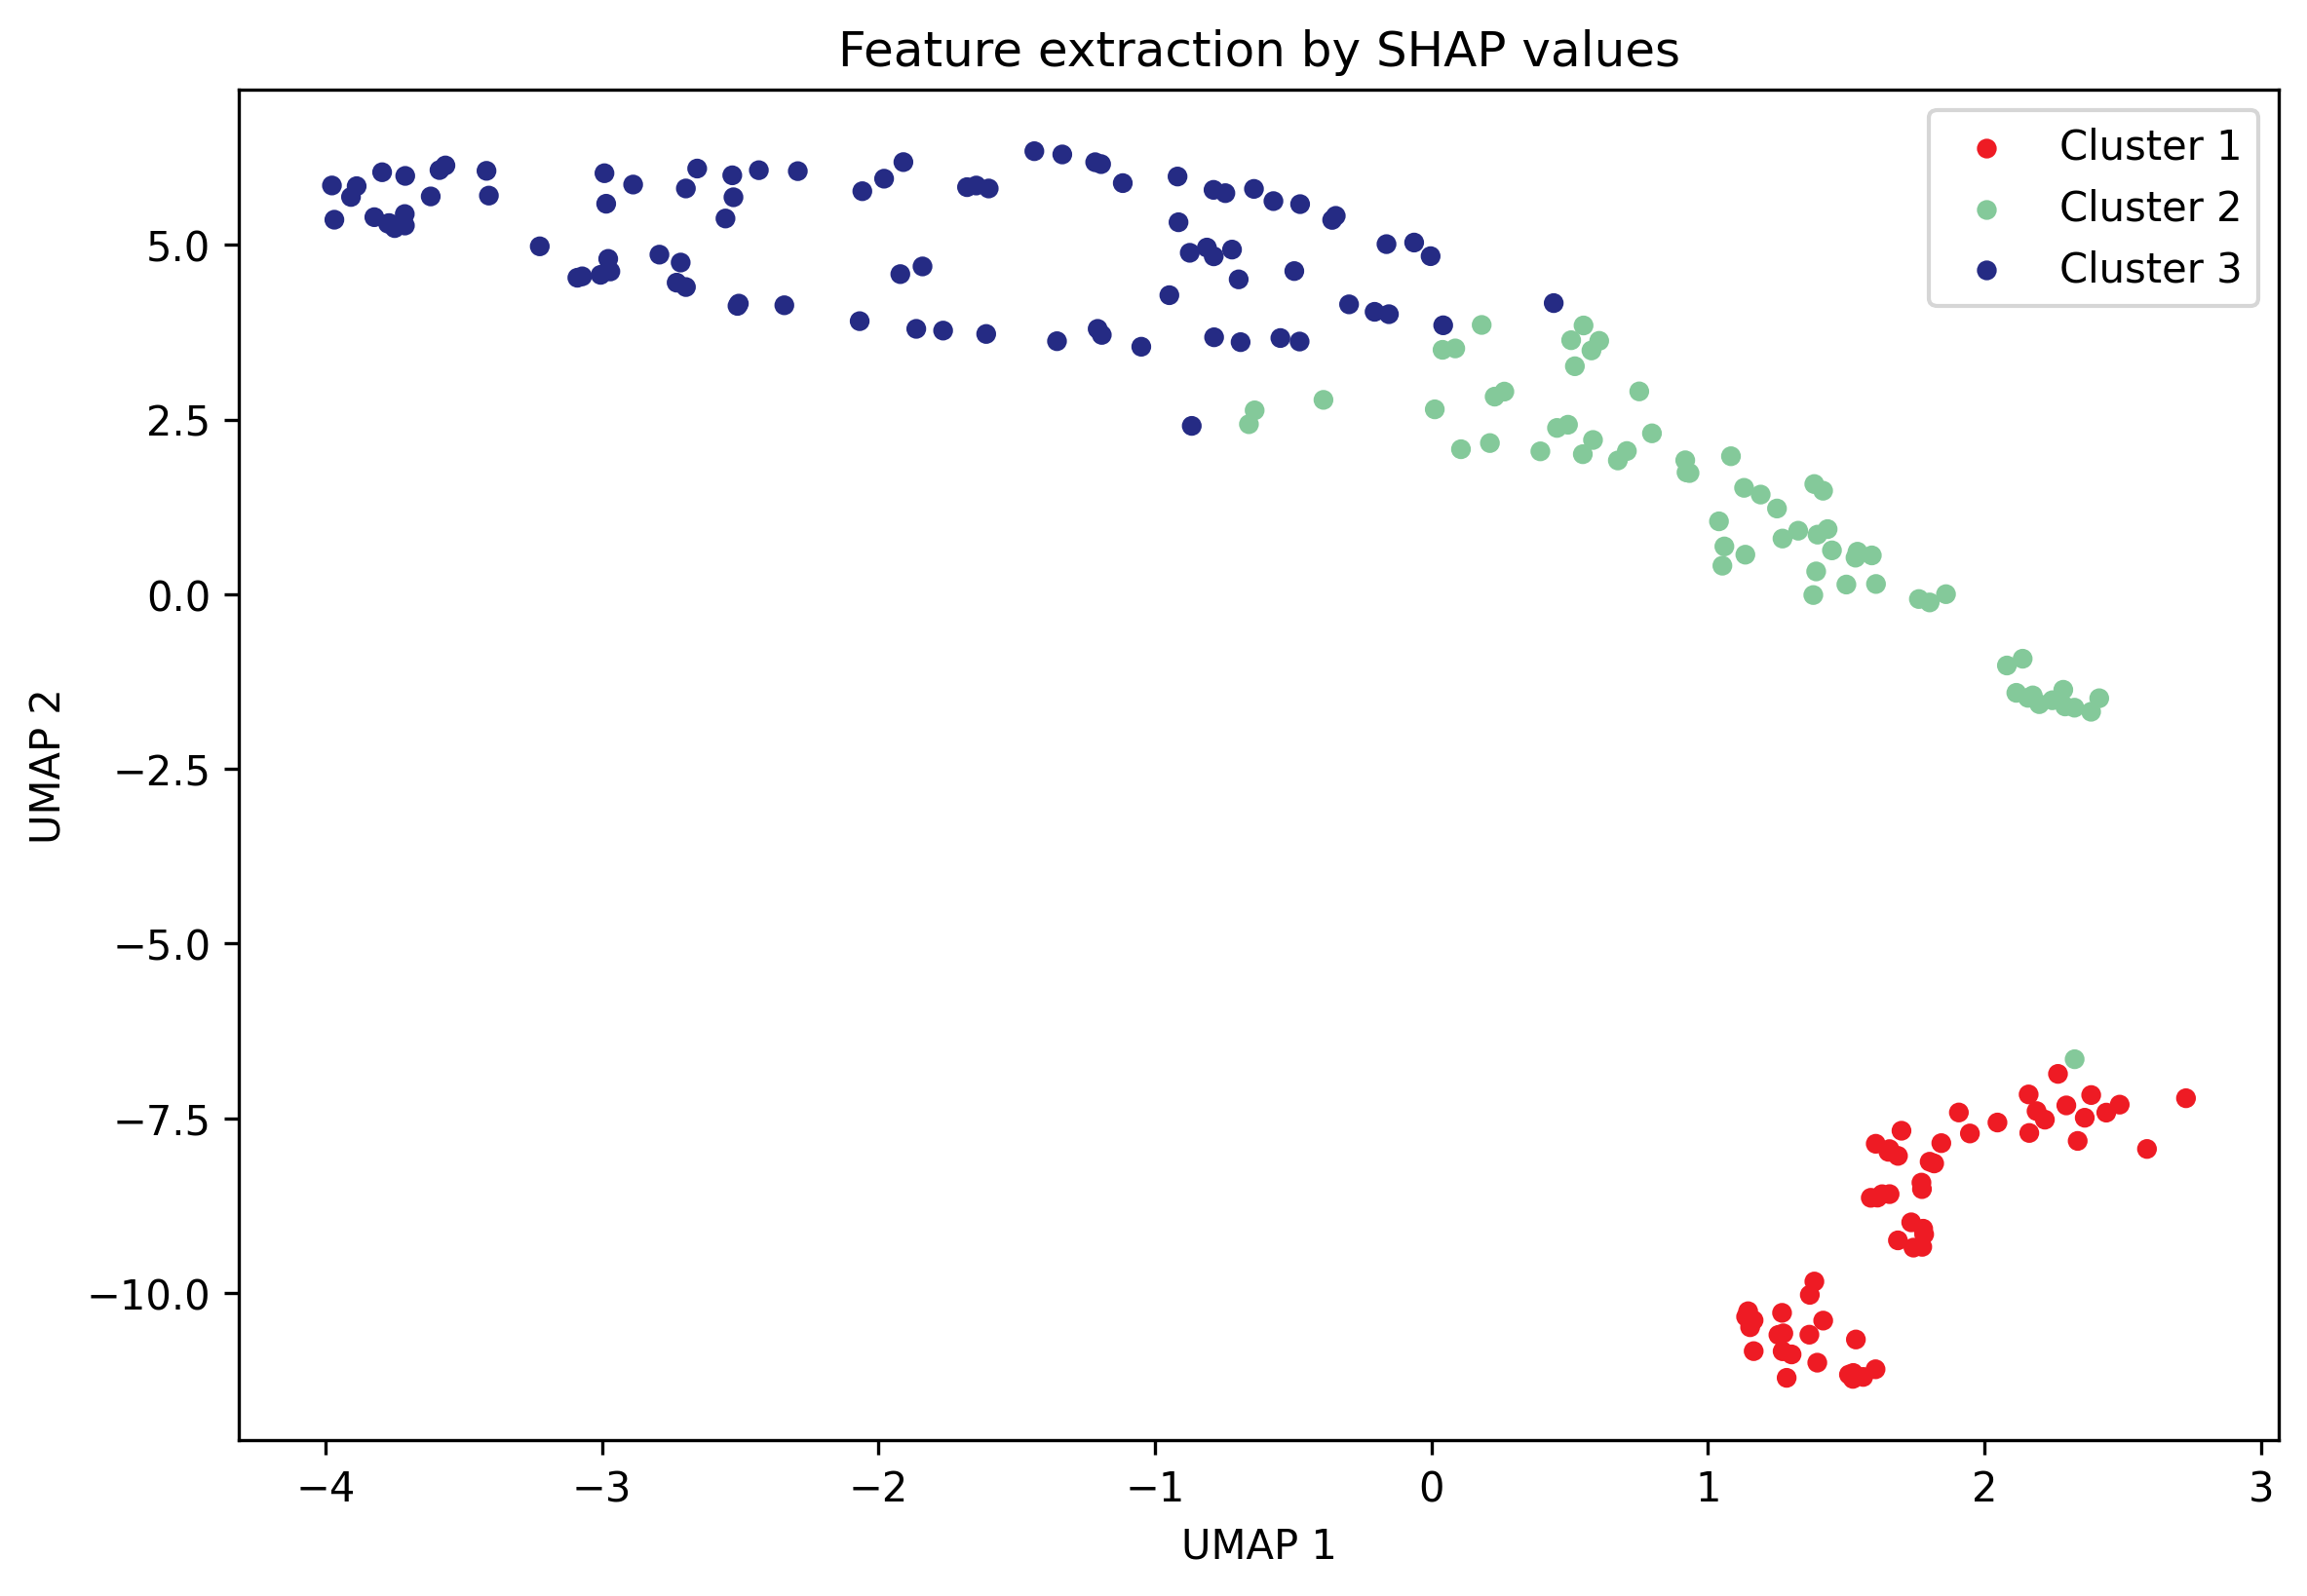

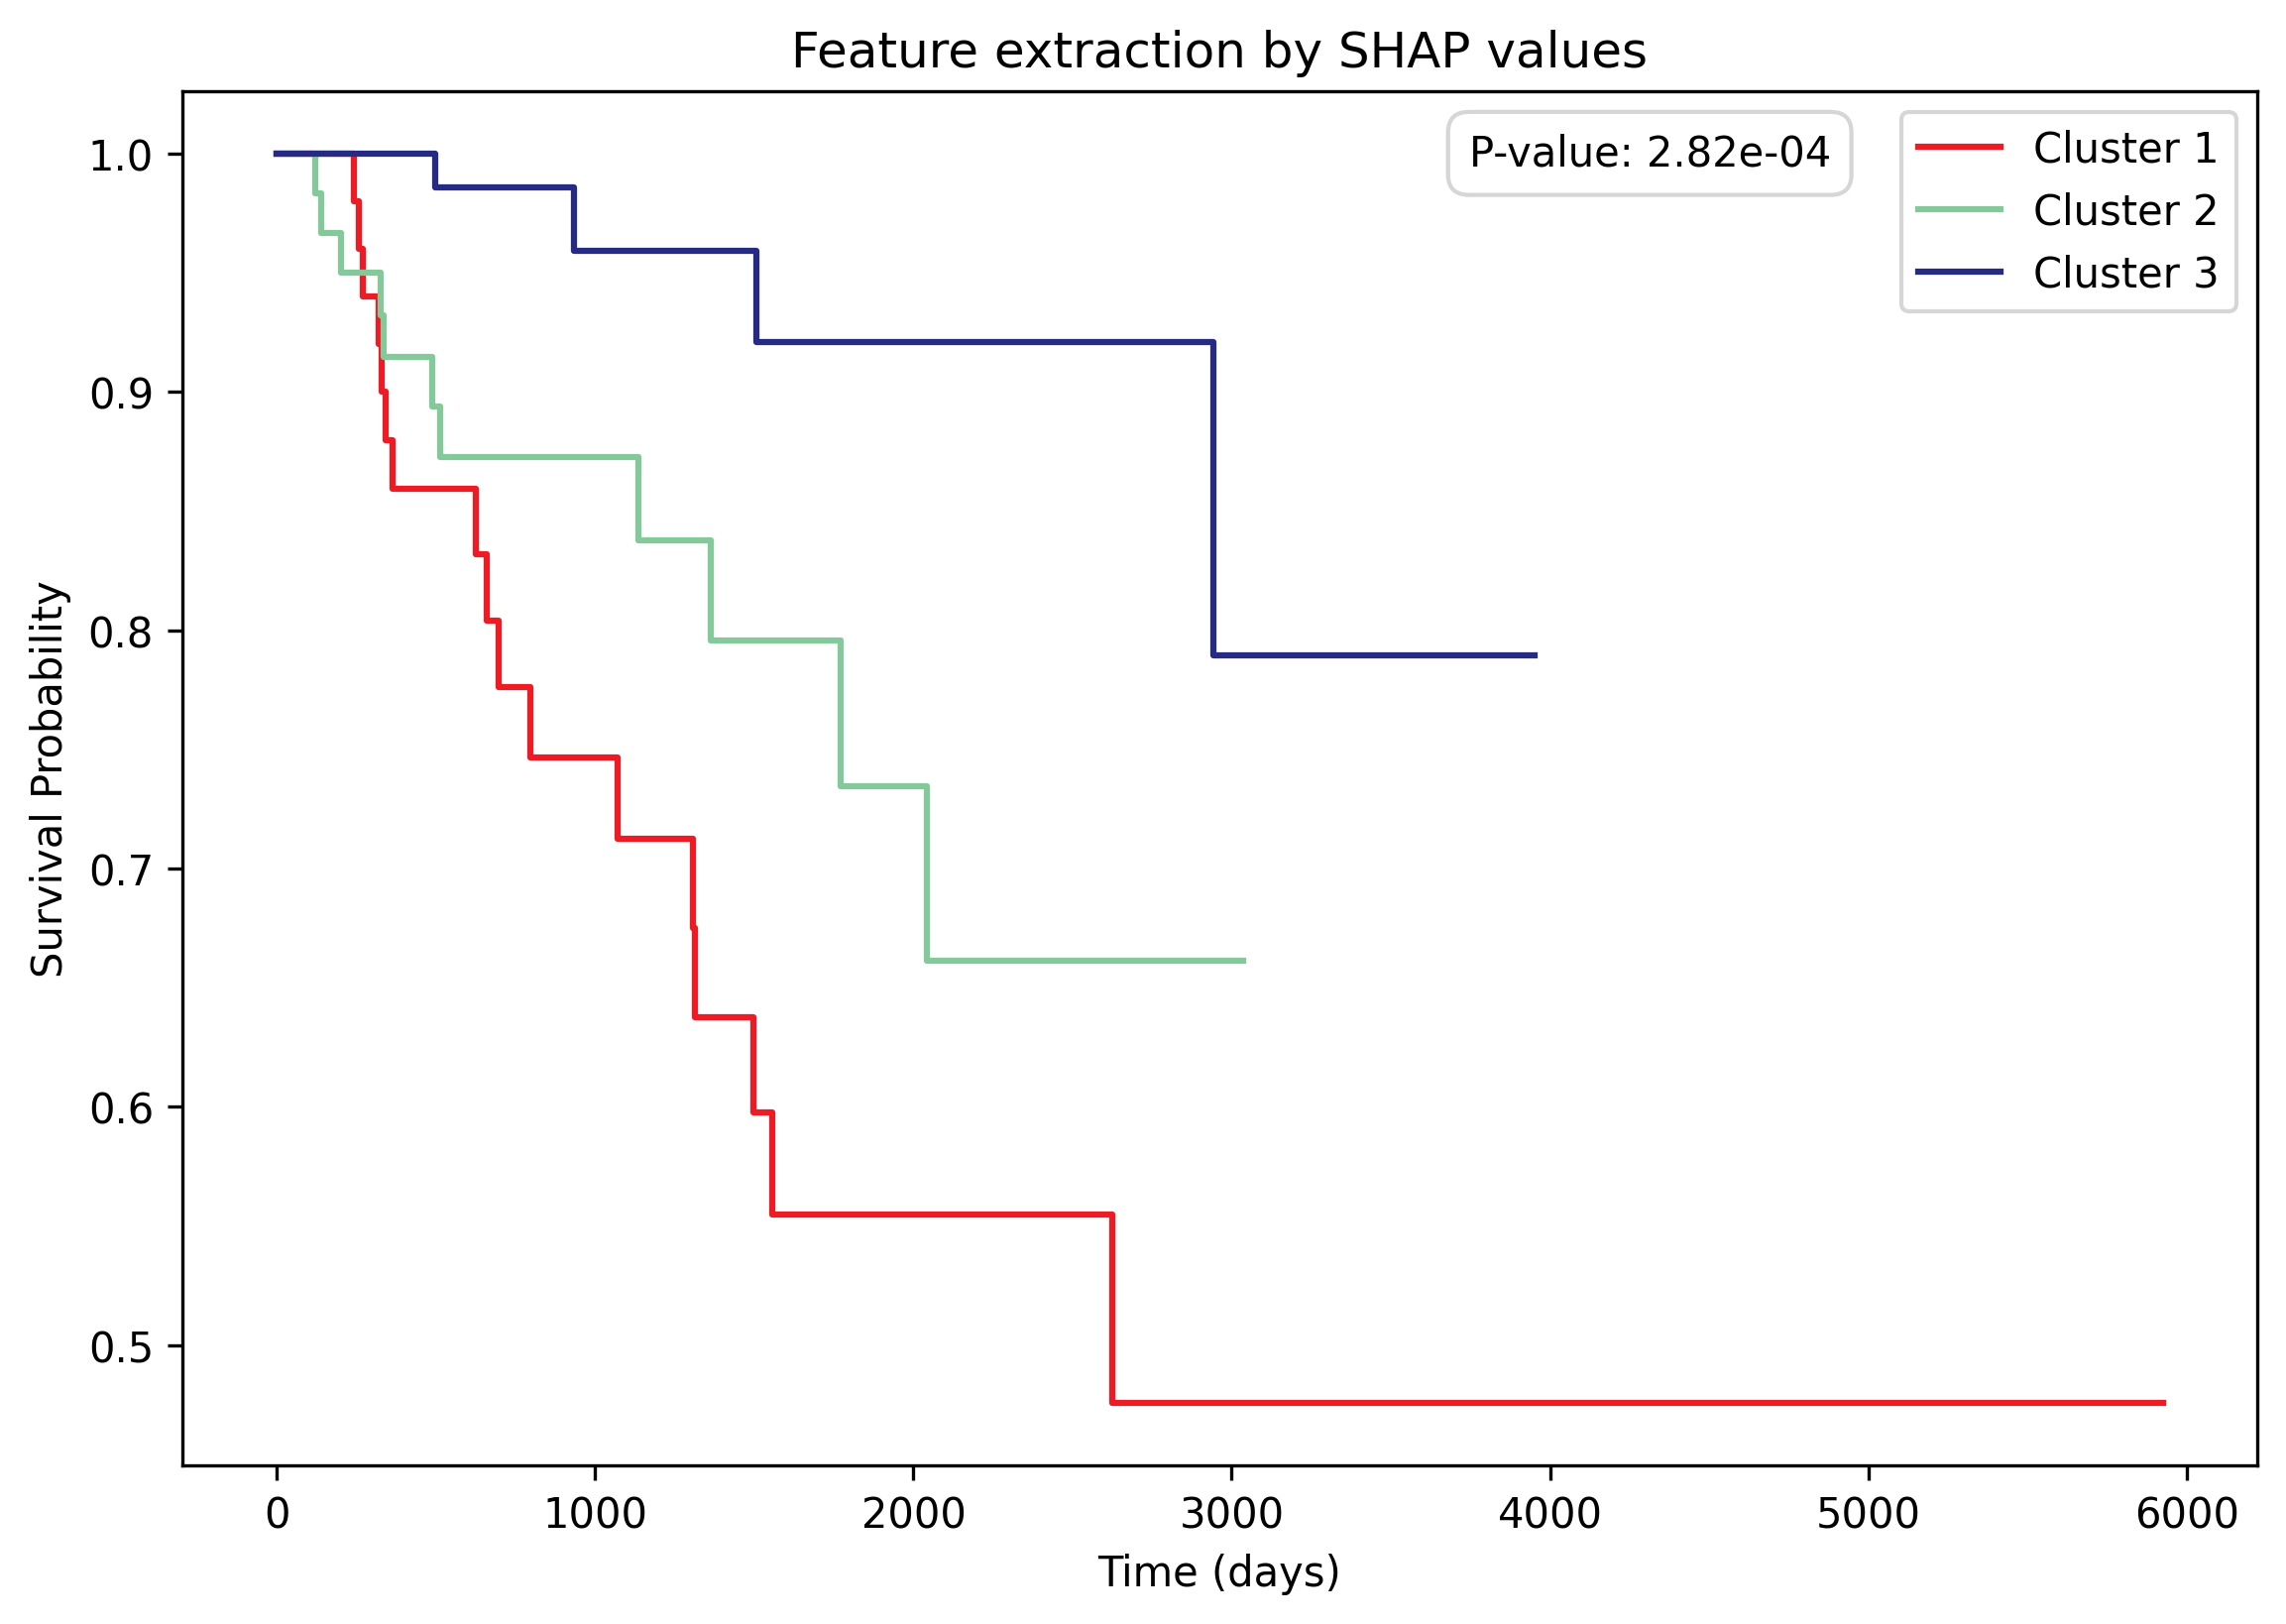

In [8]:
pandas2ri.activate()
umap = importr('umap')
cancersubtypes = importr('CancerSubtypes')
np.random.seed(2)
U1 = U[:, :2]
clusters, similar, clusternumber = spectral_clustering_nSNN(U1, 30)
clusters2 = [map_cluster_to_color(cluster) for cluster in clusters]
clusters += 1

cluster_colors = {
    1: '#EE1B24',
    2: '#84C99A',
    3: '#252B84'
}
clusters2 = [cluster_colors[cluster] for cluster in clusters]

T = clinical['Time']
E = clinical['Death']
results = multivariate_logrank_test(T, clusters, E)
p_val_avg = results.p_value

all_shap = pandas2ri.DataFrame(pd.DataFrame(U1))
sil = cancersubtypes.silhouette_SimilarityMatrix(clusters, pandas2ri.DataFrame(pd.DataFrame(similar)))
umap_result = umap.umap(all_shap, n_neighbors=35, n_components=2, seed=123)

plt.figure(figsize=(9, 6), dpi=300)
for label, color in cluster_colors.items():
    plt.scatter([], [], color=color, label=f'Cluster {label}', s=15)  
plt.scatter(umap_result.rx2("layout")[:, 0], umap_result.rx2("layout")[:, 1], color=clusters2, s=15)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.title('Feature extraction by SHAP values')
plt.show()

plt.figure(figsize=(9, 6), dpi=300)
kmf = KaplanMeierFitter()
for label in set(clusters):
    mask = (clusters == label)
    kmf.fit(clinical['Time'][mask], event_observed=clinical['Death'][mask], label=f'Cluster {label}')
    kmf.plot(ci_show=False, color=cluster_colors[label])  
plt.text(0.62, 0.97, f'P-value: {format(p_val_avg, ".2e")}', 
         horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', edgecolor='#D6D6D6', boxstyle='round,pad=0.5'))
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.title('Feature extraction by SHAP values')
plt.show()


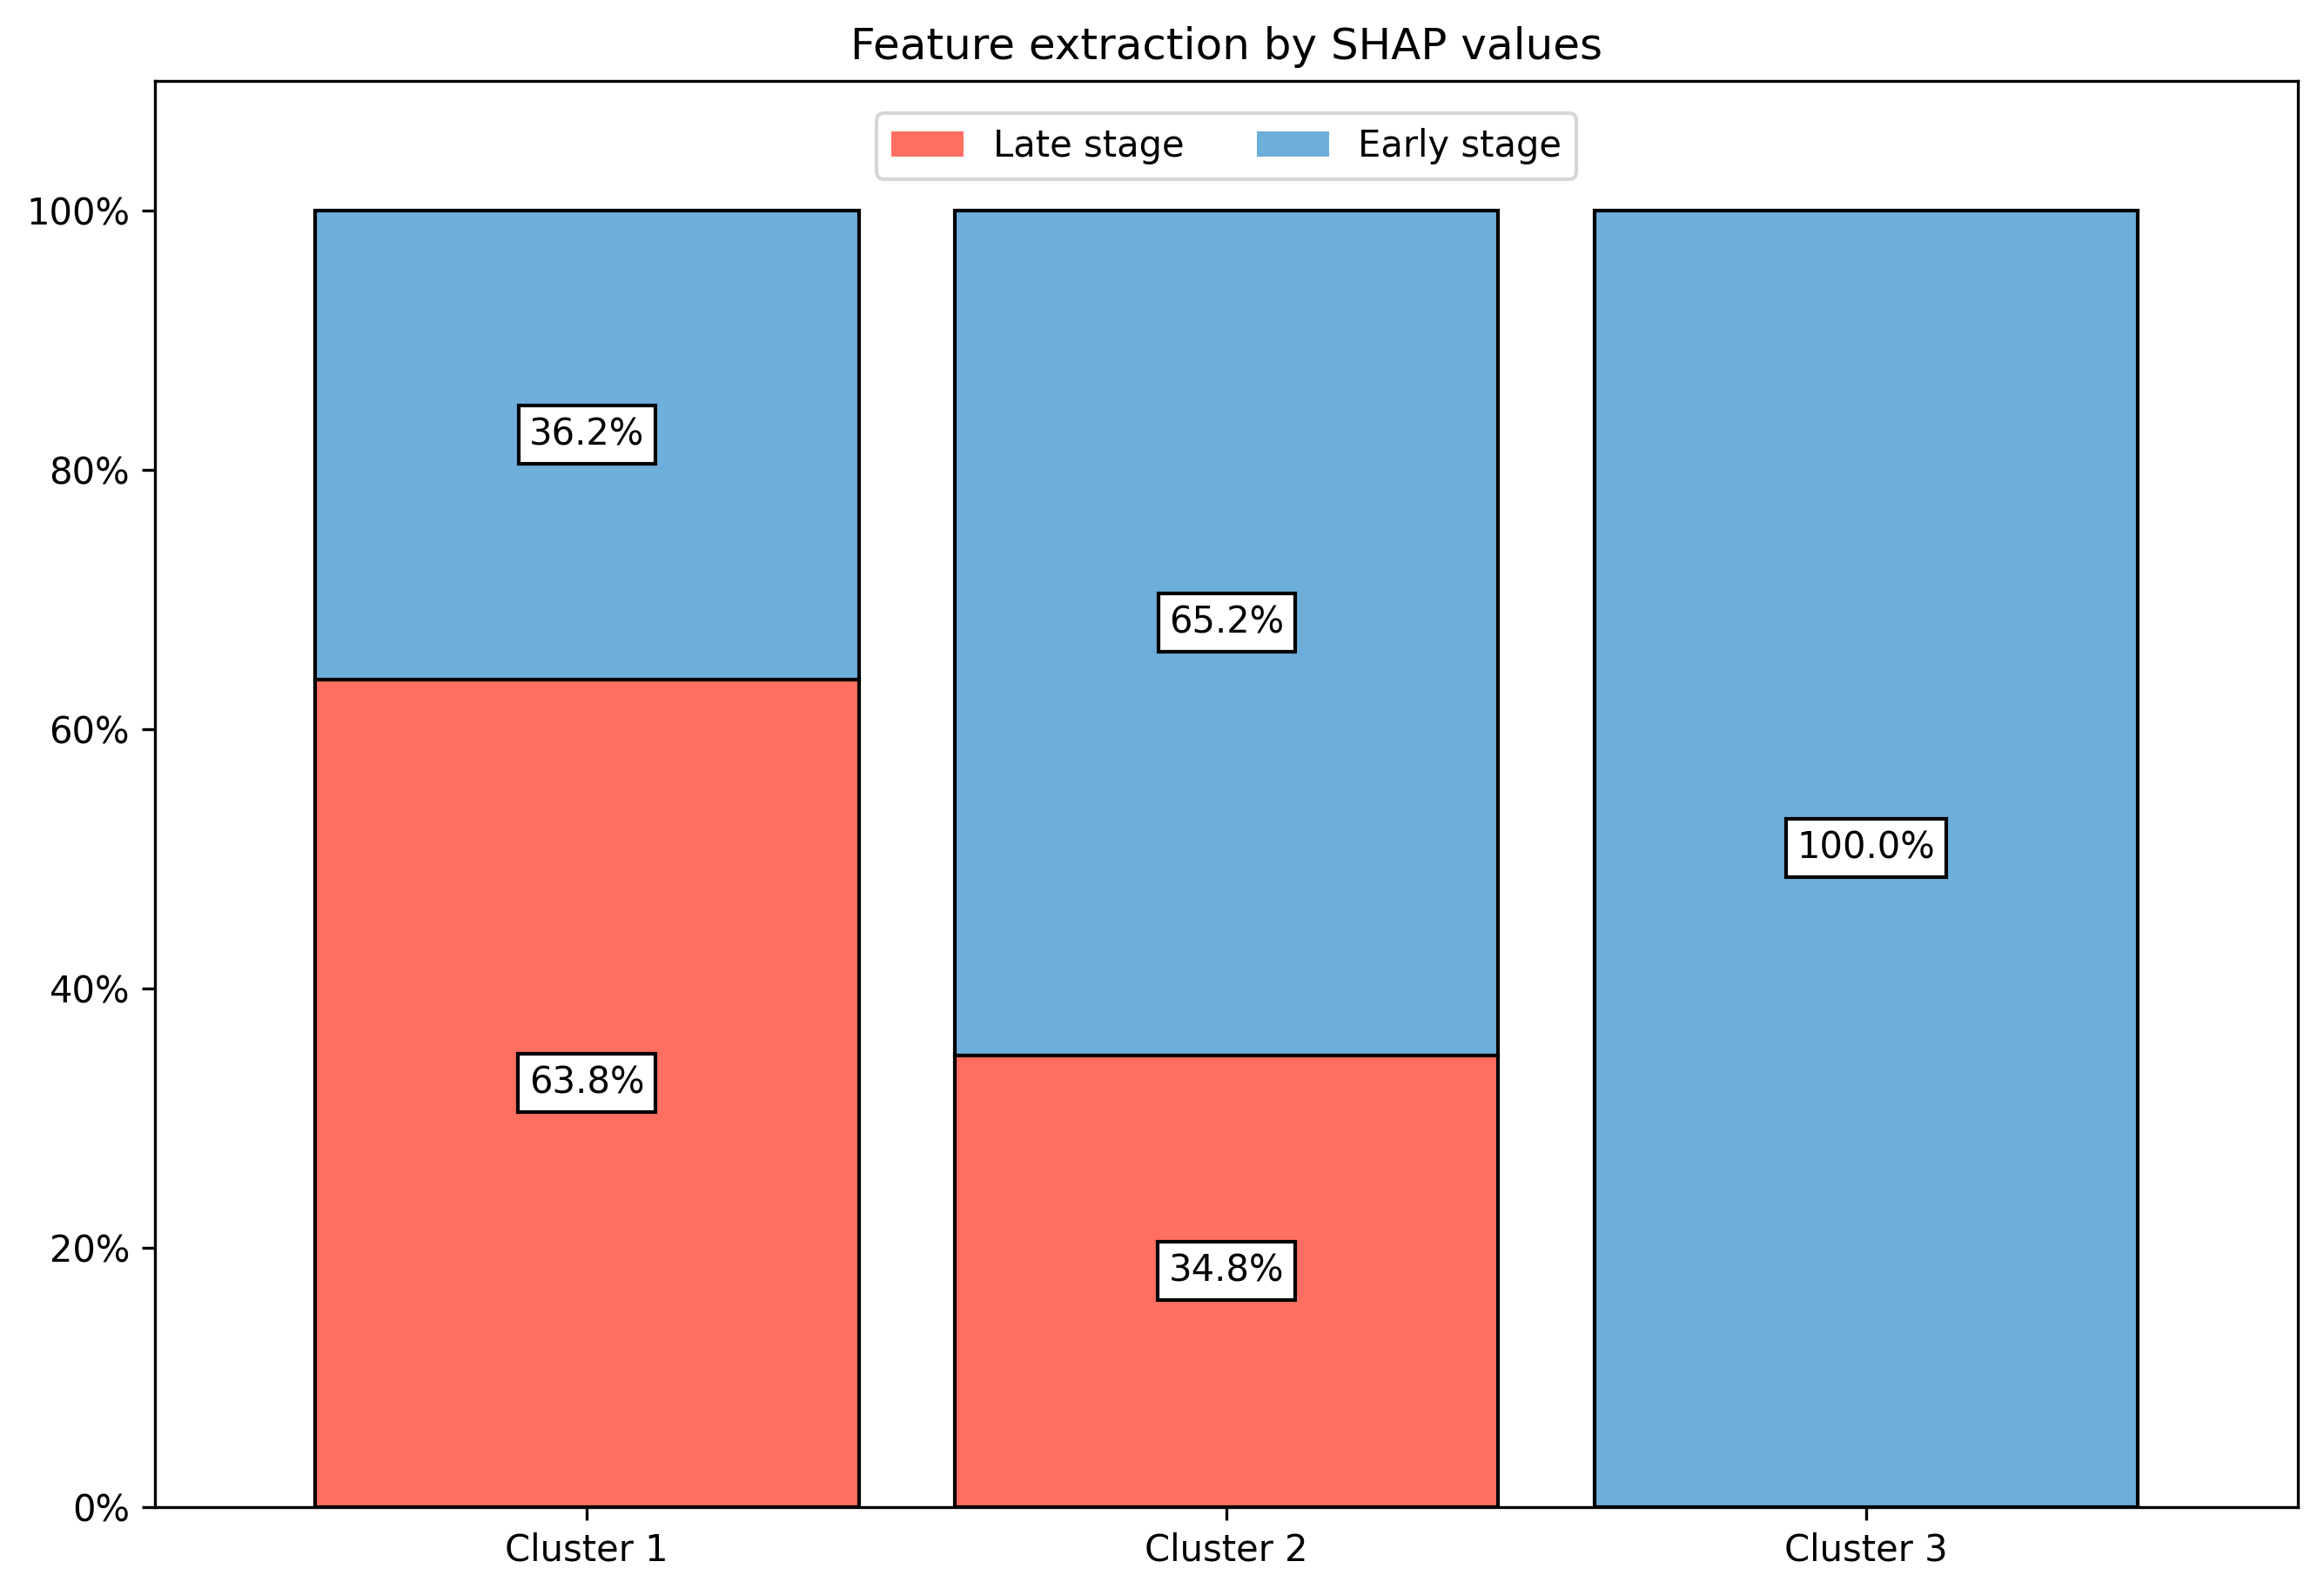

In [12]:
df_cnt_degs_norm = pd.DataFrame(U1)
df_cnt_degs_norm['cluster'] = clusters
df_cnt_degs_norm['label'] = pathoS

cluster_label_ratios = df_cnt_degs_norm.groupby(['cluster', 'label']).size().unstack(fill_value=0)
cluster_label_ratios = cluster_label_ratios.div(cluster_label_ratios.sum(axis=1), axis=0)
cluster_label_ratios = cluster_label_ratios.reindex(columns=[1.0, 0.0])

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
colors = {'label_1': '#6DAEDB', 'label_0': '#FF6F61'}


bar_width = 0.85
cluster_sample_counts = df_cnt_degs_norm['cluster'].value_counts().sort_index()
bars = cluster_label_ratios.plot(kind='bar', stacked=True, ax=ax, color=[colors[f'label_{i}'] for i in range(len(cluster_label_ratios.columns))], width=bar_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(range(len(cluster_sample_counts)), [f'Cluster {i + 1}' for i in range(len(cluster_sample_counts))], rotation=0)
plt.legend(labels=['Late stage', 'Early stage'],  bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=2)

for i, count in enumerate(cluster_sample_counts):
    total_height = 0
    for j in range(len(cluster_label_ratios.columns)):
        label_ratio = cluster_label_ratios.iloc[i, j]
        if label_ratio != 0: 
            ax.text(i, total_height + label_ratio / 2, f'{label_ratio:.1%}', ha='center', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=3))
        total_height += label_ratio

for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.title('Feature extraction by SHAP values')
plt.show()


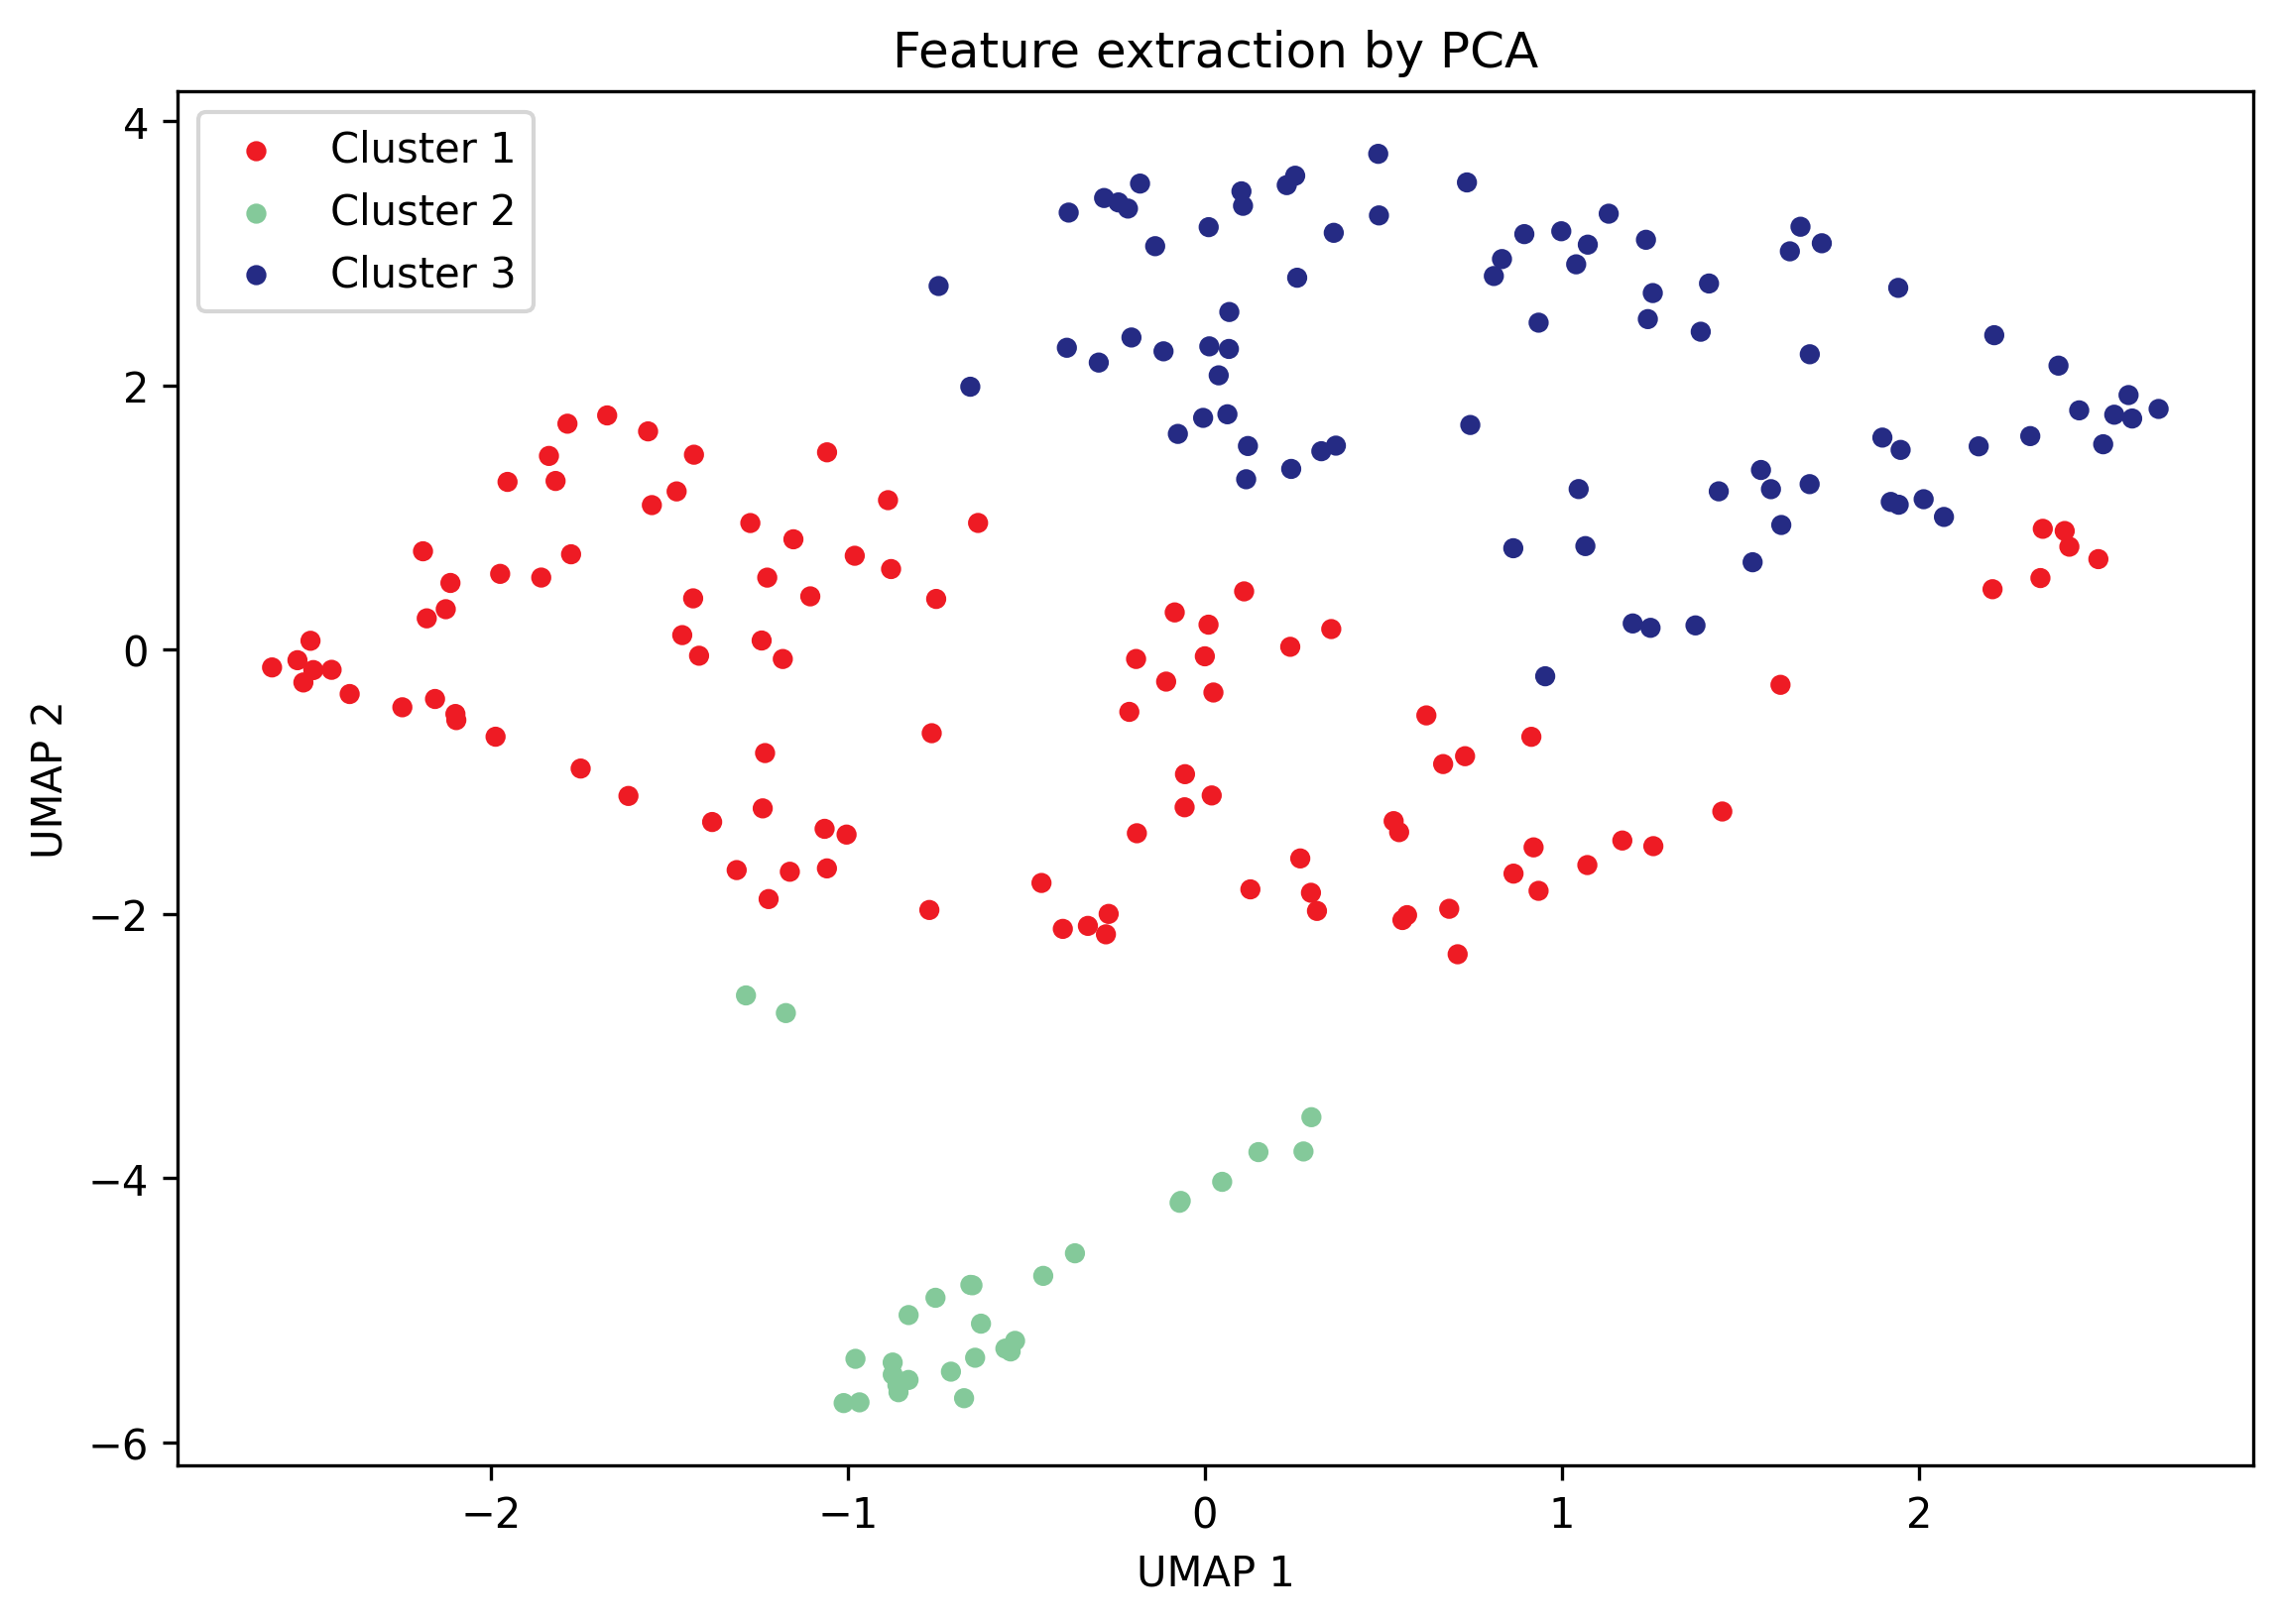

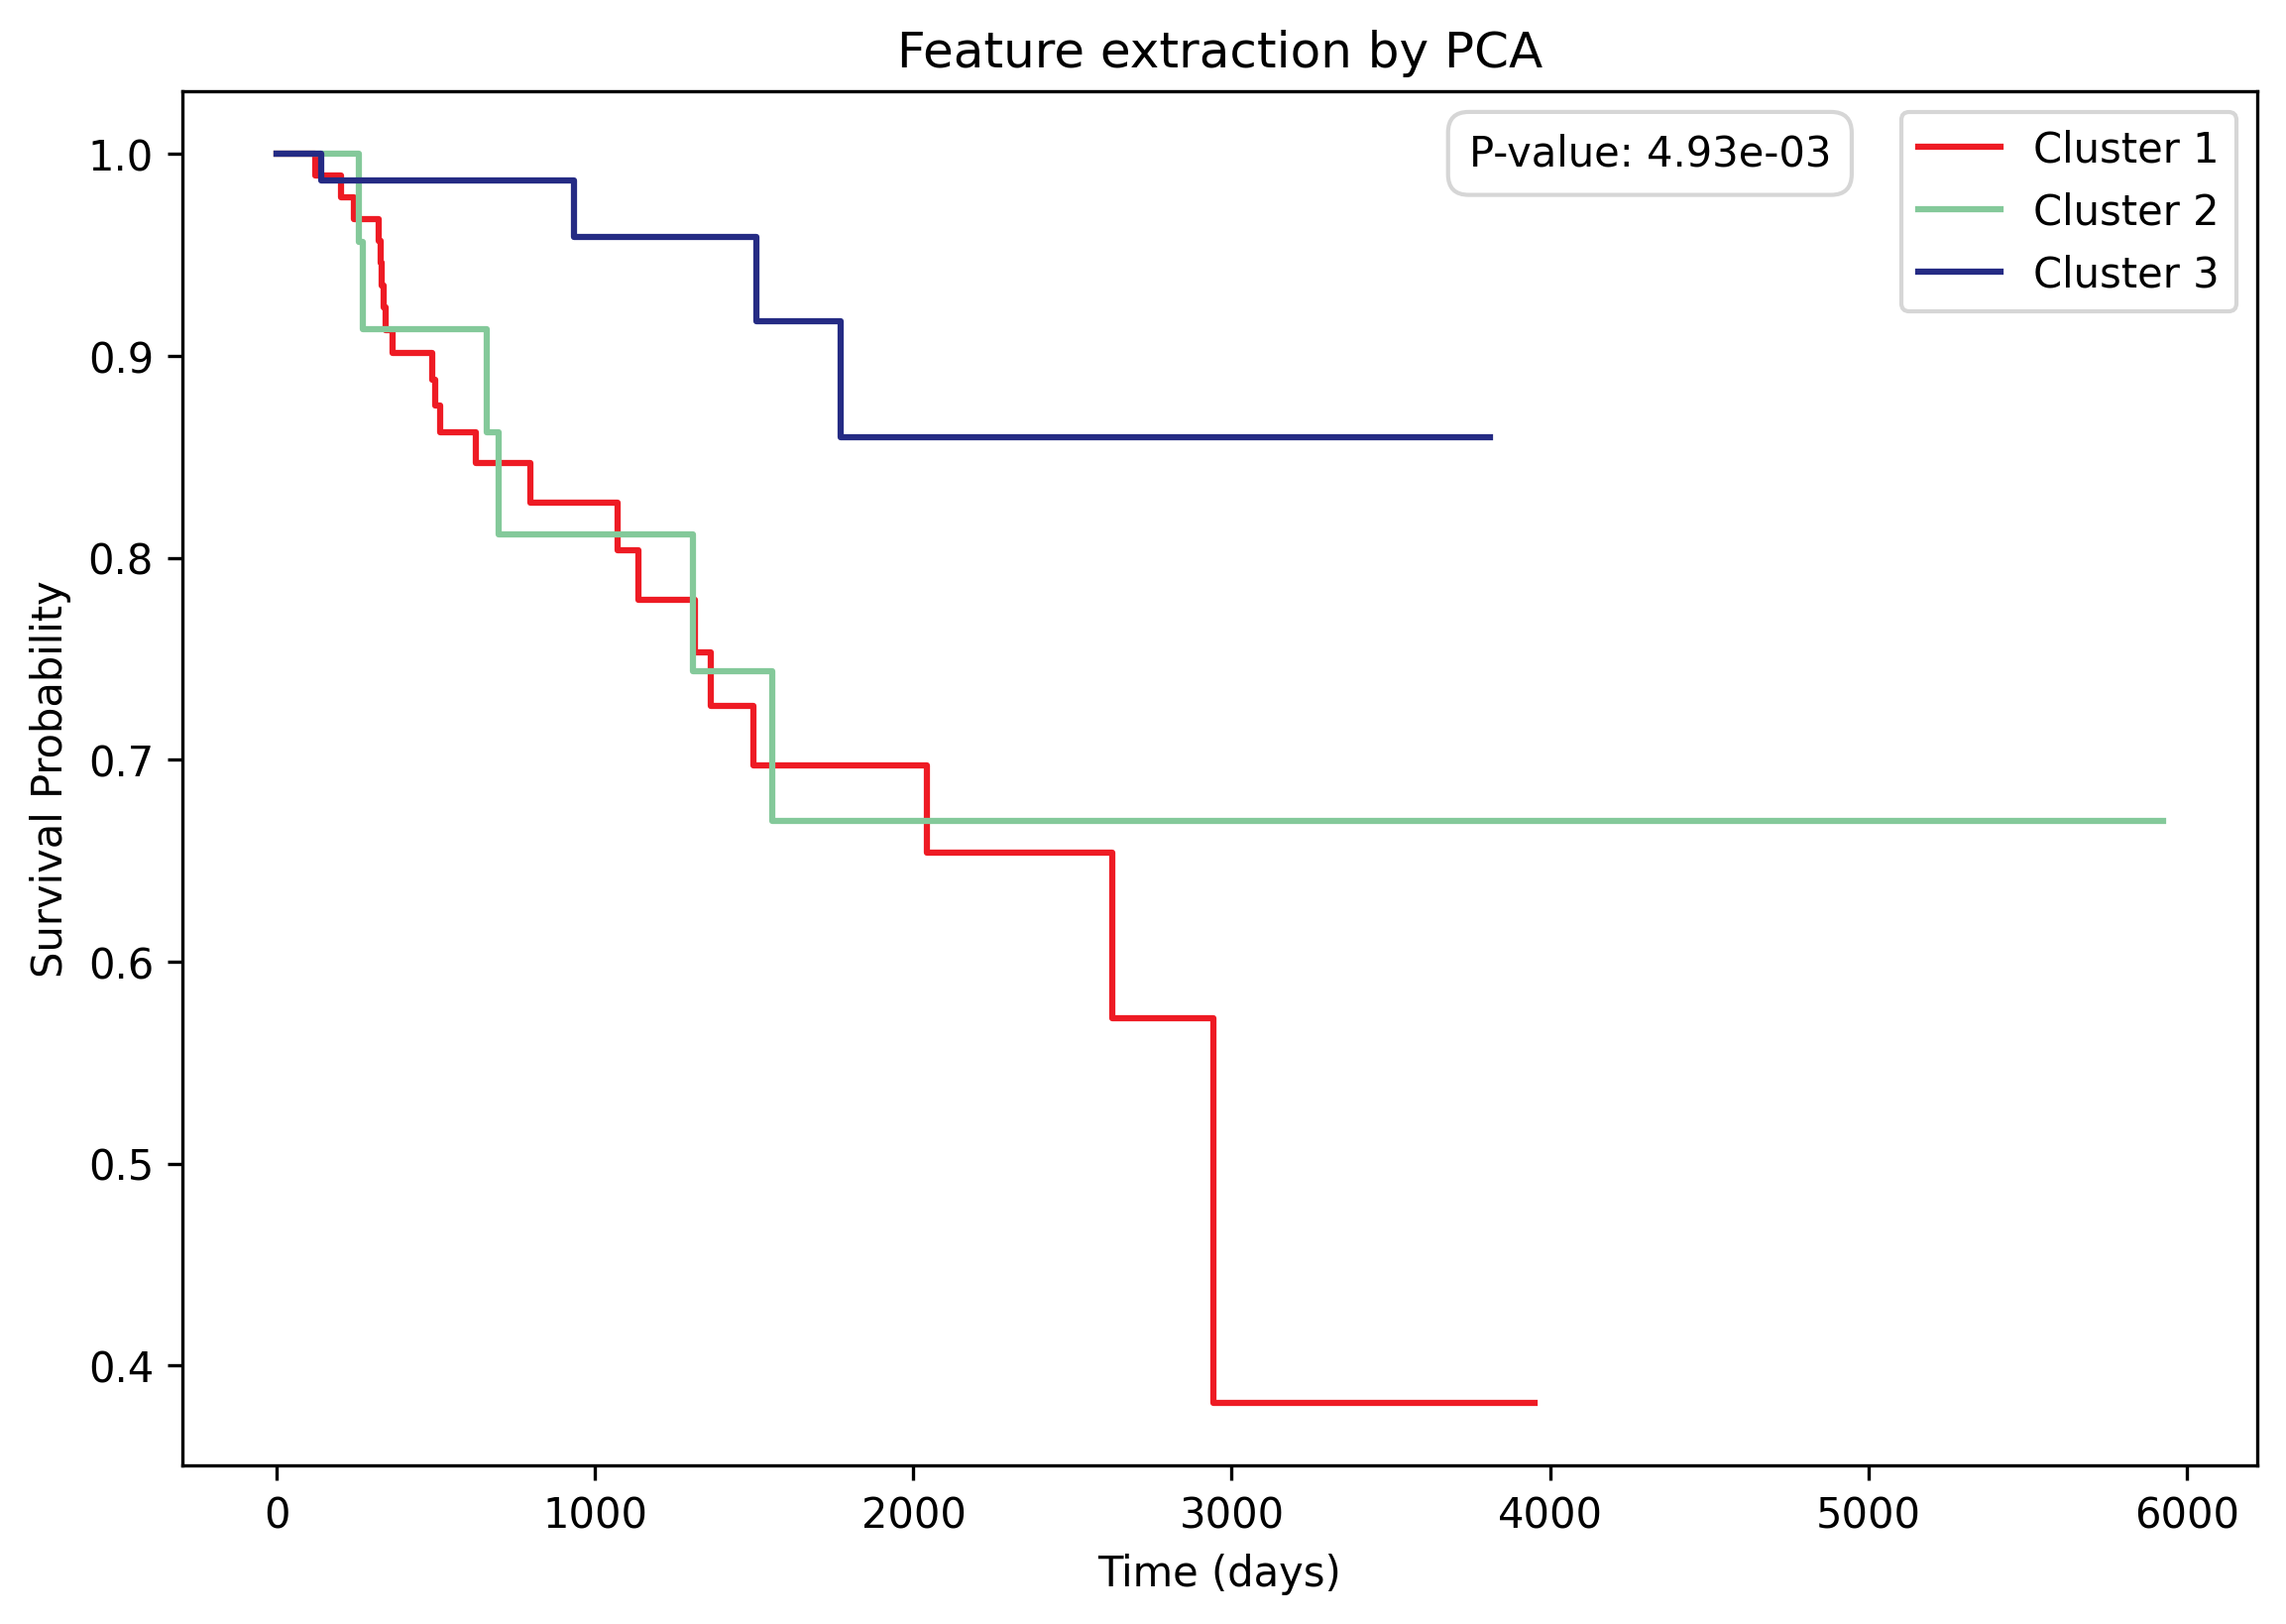

In [14]:
mRNA_pca = PCA().fit_transform(gene.values)
Methy_pca = PCA().fit_transform(methy.values)
miRNA_pca = PCA().fit_transform(mirna.values)

pandas2ri.activate()
umap = importr('umap')
cancersubtypes = importr('CancerSubtypes')


completed_data = np.concatenate([mRNA_pca[:, :2], Methy_pca[:, :2], miRNA_pca[:, :2]], axis=1)
U, _, _ = np.linalg.svd(completed_data)

U1 = U[:, :3]
clusters, similarities, number = spectral_clustering_nSNN(U1, 5)  
clusters2 = [map_cluster_to_color(cluster) for cluster in clusters]

clusters += 1

cluster_colors = {
    1: '#EE1B24',
    2: '#84C99A',
    3: '#252B84'
}
clusters2 = [cluster_colors[cluster] for cluster in clusters]

T = clinical['Time']
E = clinical['Death']
results = multivariate_logrank_test(T, clusters, E)
p_val_avg = results.p_value

all_shap = pandas2ri.DataFrame(pd.DataFrame(U1))
sil = cancersubtypes.silhouette_SimilarityMatrix(clusters, pandas2ri.DataFrame(pd.DataFrame(similar)))
umap_result = umap.umap(all_shap, n_neighbors=35, n_components=2, seed=123)

plt.figure(figsize=(9, 6), dpi=300)
for label, color in cluster_colors.items():
    plt.scatter([], [], color=color, label=f'Cluster {label}', s=15)  
plt.scatter(umap_result.rx2("layout")[:, 0], umap_result.rx2("layout")[:, 1], color=clusters2, s=15)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.title('Feature extraction by PCA')
plt.show()

plt.figure(figsize=(9, 6), dpi=300)
kmf = KaplanMeierFitter()
for label in set(clusters):
    mask = (clusters == label)
    kmf.fit(clinical['Time'][mask], event_observed=clinical['Death'][mask], label=f'Cluster {label}')
    kmf.plot(ci_show=False, color=cluster_colors[label]) 
plt.text(0.62, 0.97, f'P-value: {format(p_val_avg, ".2e")}', 
         horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', edgecolor='#D6D6D6', boxstyle='round,pad=0.5'))
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.title('Feature extraction by PCA')
plt.show()

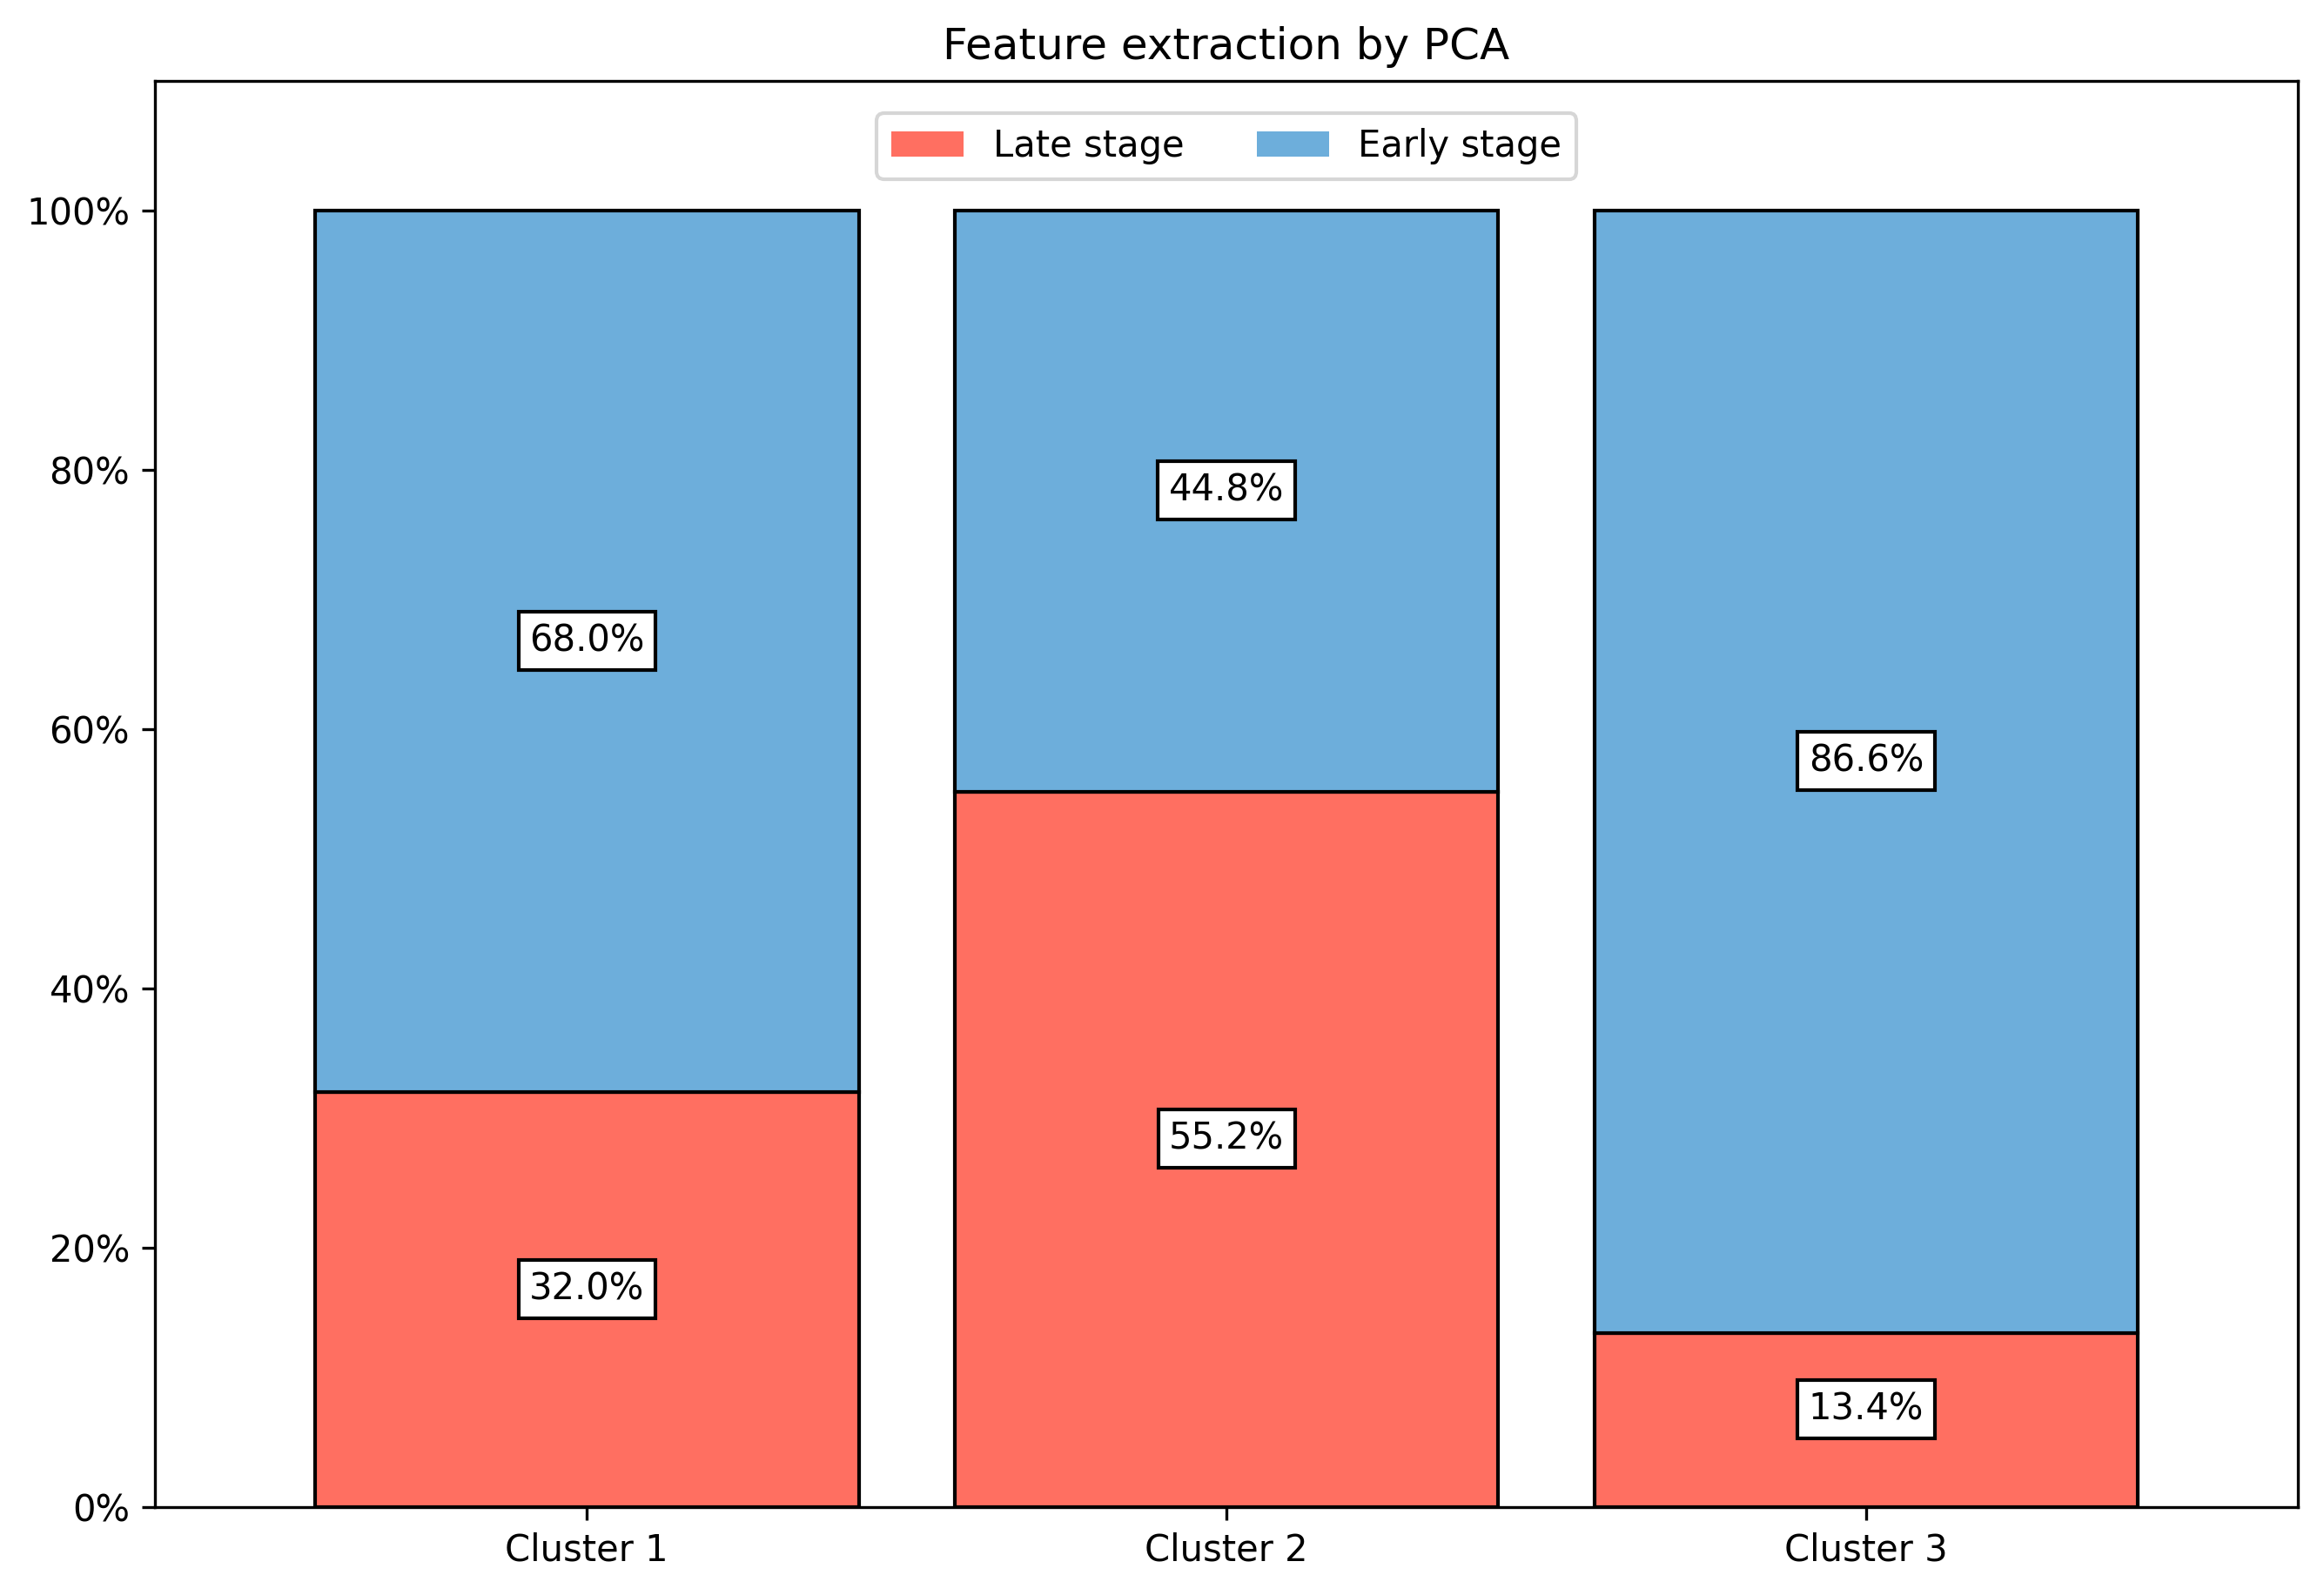

In [15]:
df_cnt_degs_norm = pd.DataFrame(U1)
df_cnt_degs_norm['cluster'] = clusters
df_cnt_degs_norm['label'] = pathoS

cluster_label_ratios = df_cnt_degs_norm.groupby(['cluster', 'label']).size().unstack(fill_value=0)
cluster_label_ratios = cluster_label_ratios.div(cluster_label_ratios.sum(axis=1), axis=0)
cluster_label_ratios = cluster_label_ratios.reindex(columns=[1.0, 0.0])

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
colors = {'label_1': '#6DAEDB', 'label_0': '#FF6F61'}

bar_width = 0.85
cluster_sample_counts = df_cnt_degs_norm['cluster'].value_counts().sort_index()
bars = cluster_label_ratios.plot(kind='bar', stacked=True, ax=ax, color=[colors[f'label_{i}'] for i in range(len(cluster_label_ratios.columns))], width=bar_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(range(len(cluster_sample_counts)), [f'Cluster {i + 1}' for i in range(len(cluster_sample_counts))], rotation=0)

plt.legend(labels=['Late stage', 'Early stage'],  bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=2)

for i, count in enumerate(cluster_sample_counts):
    #ax.text(i, -0.08, f'(n={count})', ha='center')  
    total_height = 0
    for j in range(len(cluster_label_ratios.columns)):
        label_ratio = cluster_label_ratios.iloc[i, j]
        if label_ratio != 0: 
            ax.text(i, total_height + label_ratio / 2, f'{label_ratio:.1%}', ha='center', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=3))
        total_height += label_ratio

for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.title('Feature extraction by PCA')
plt.show()


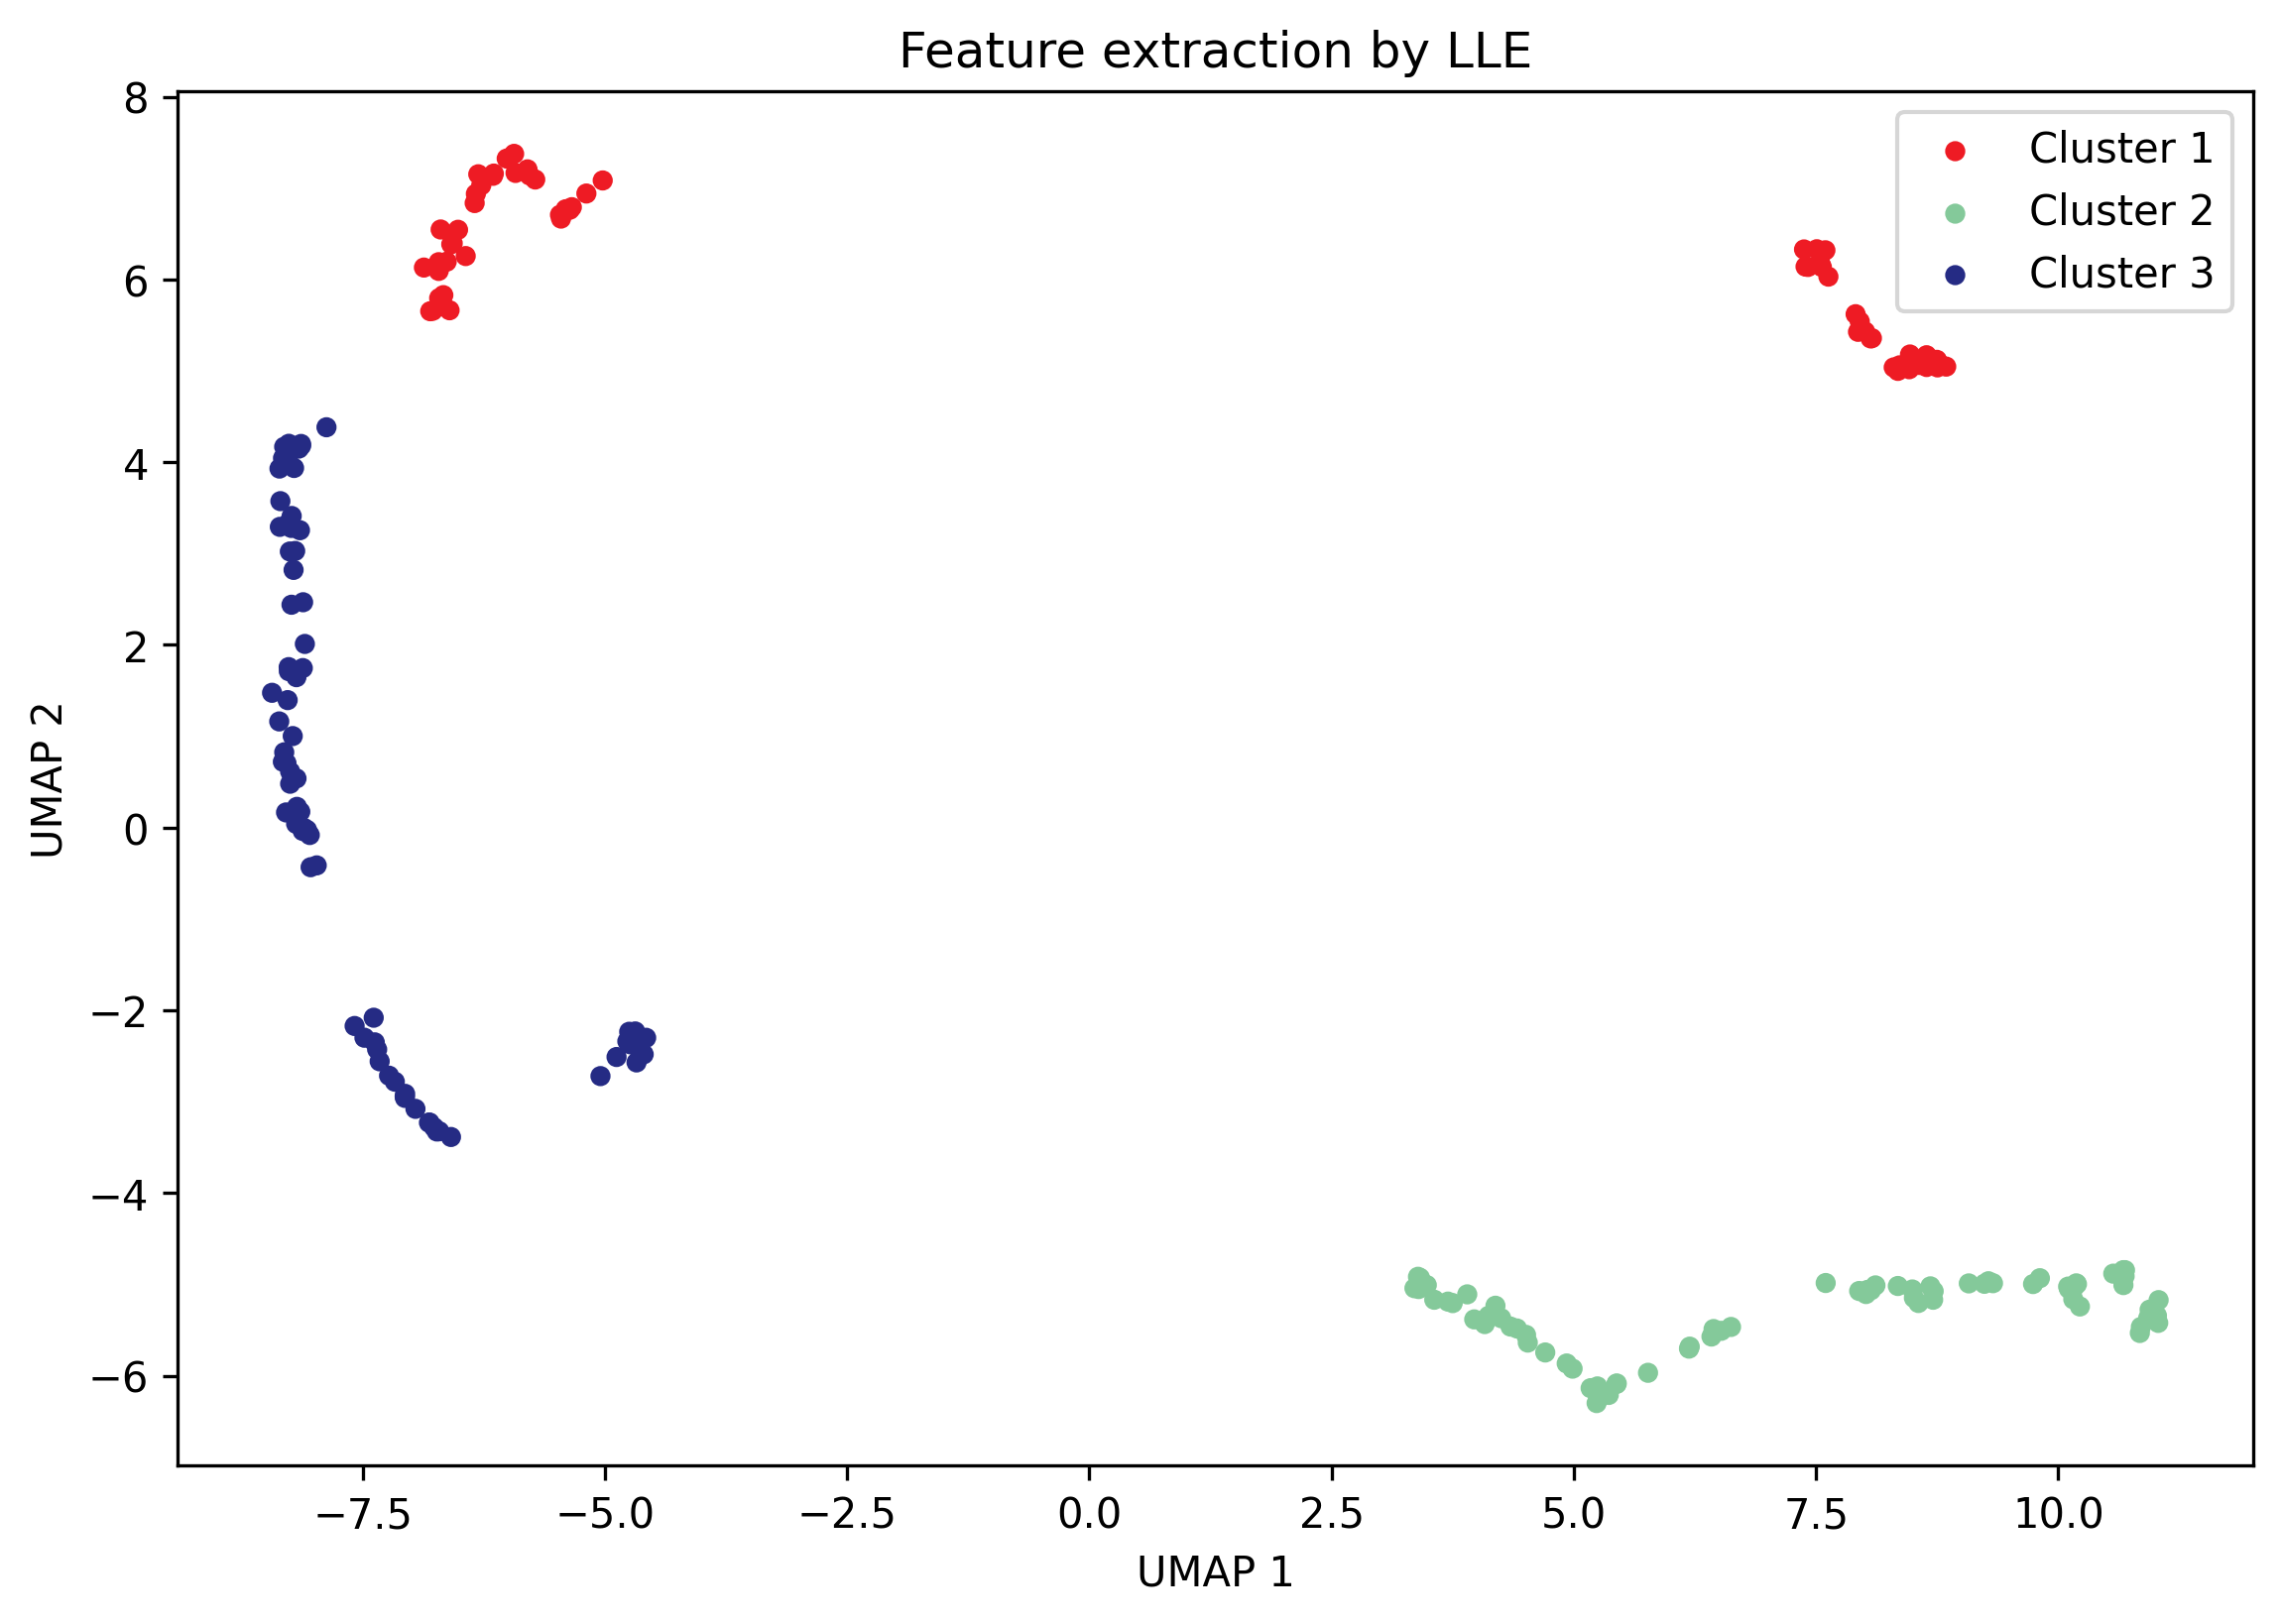

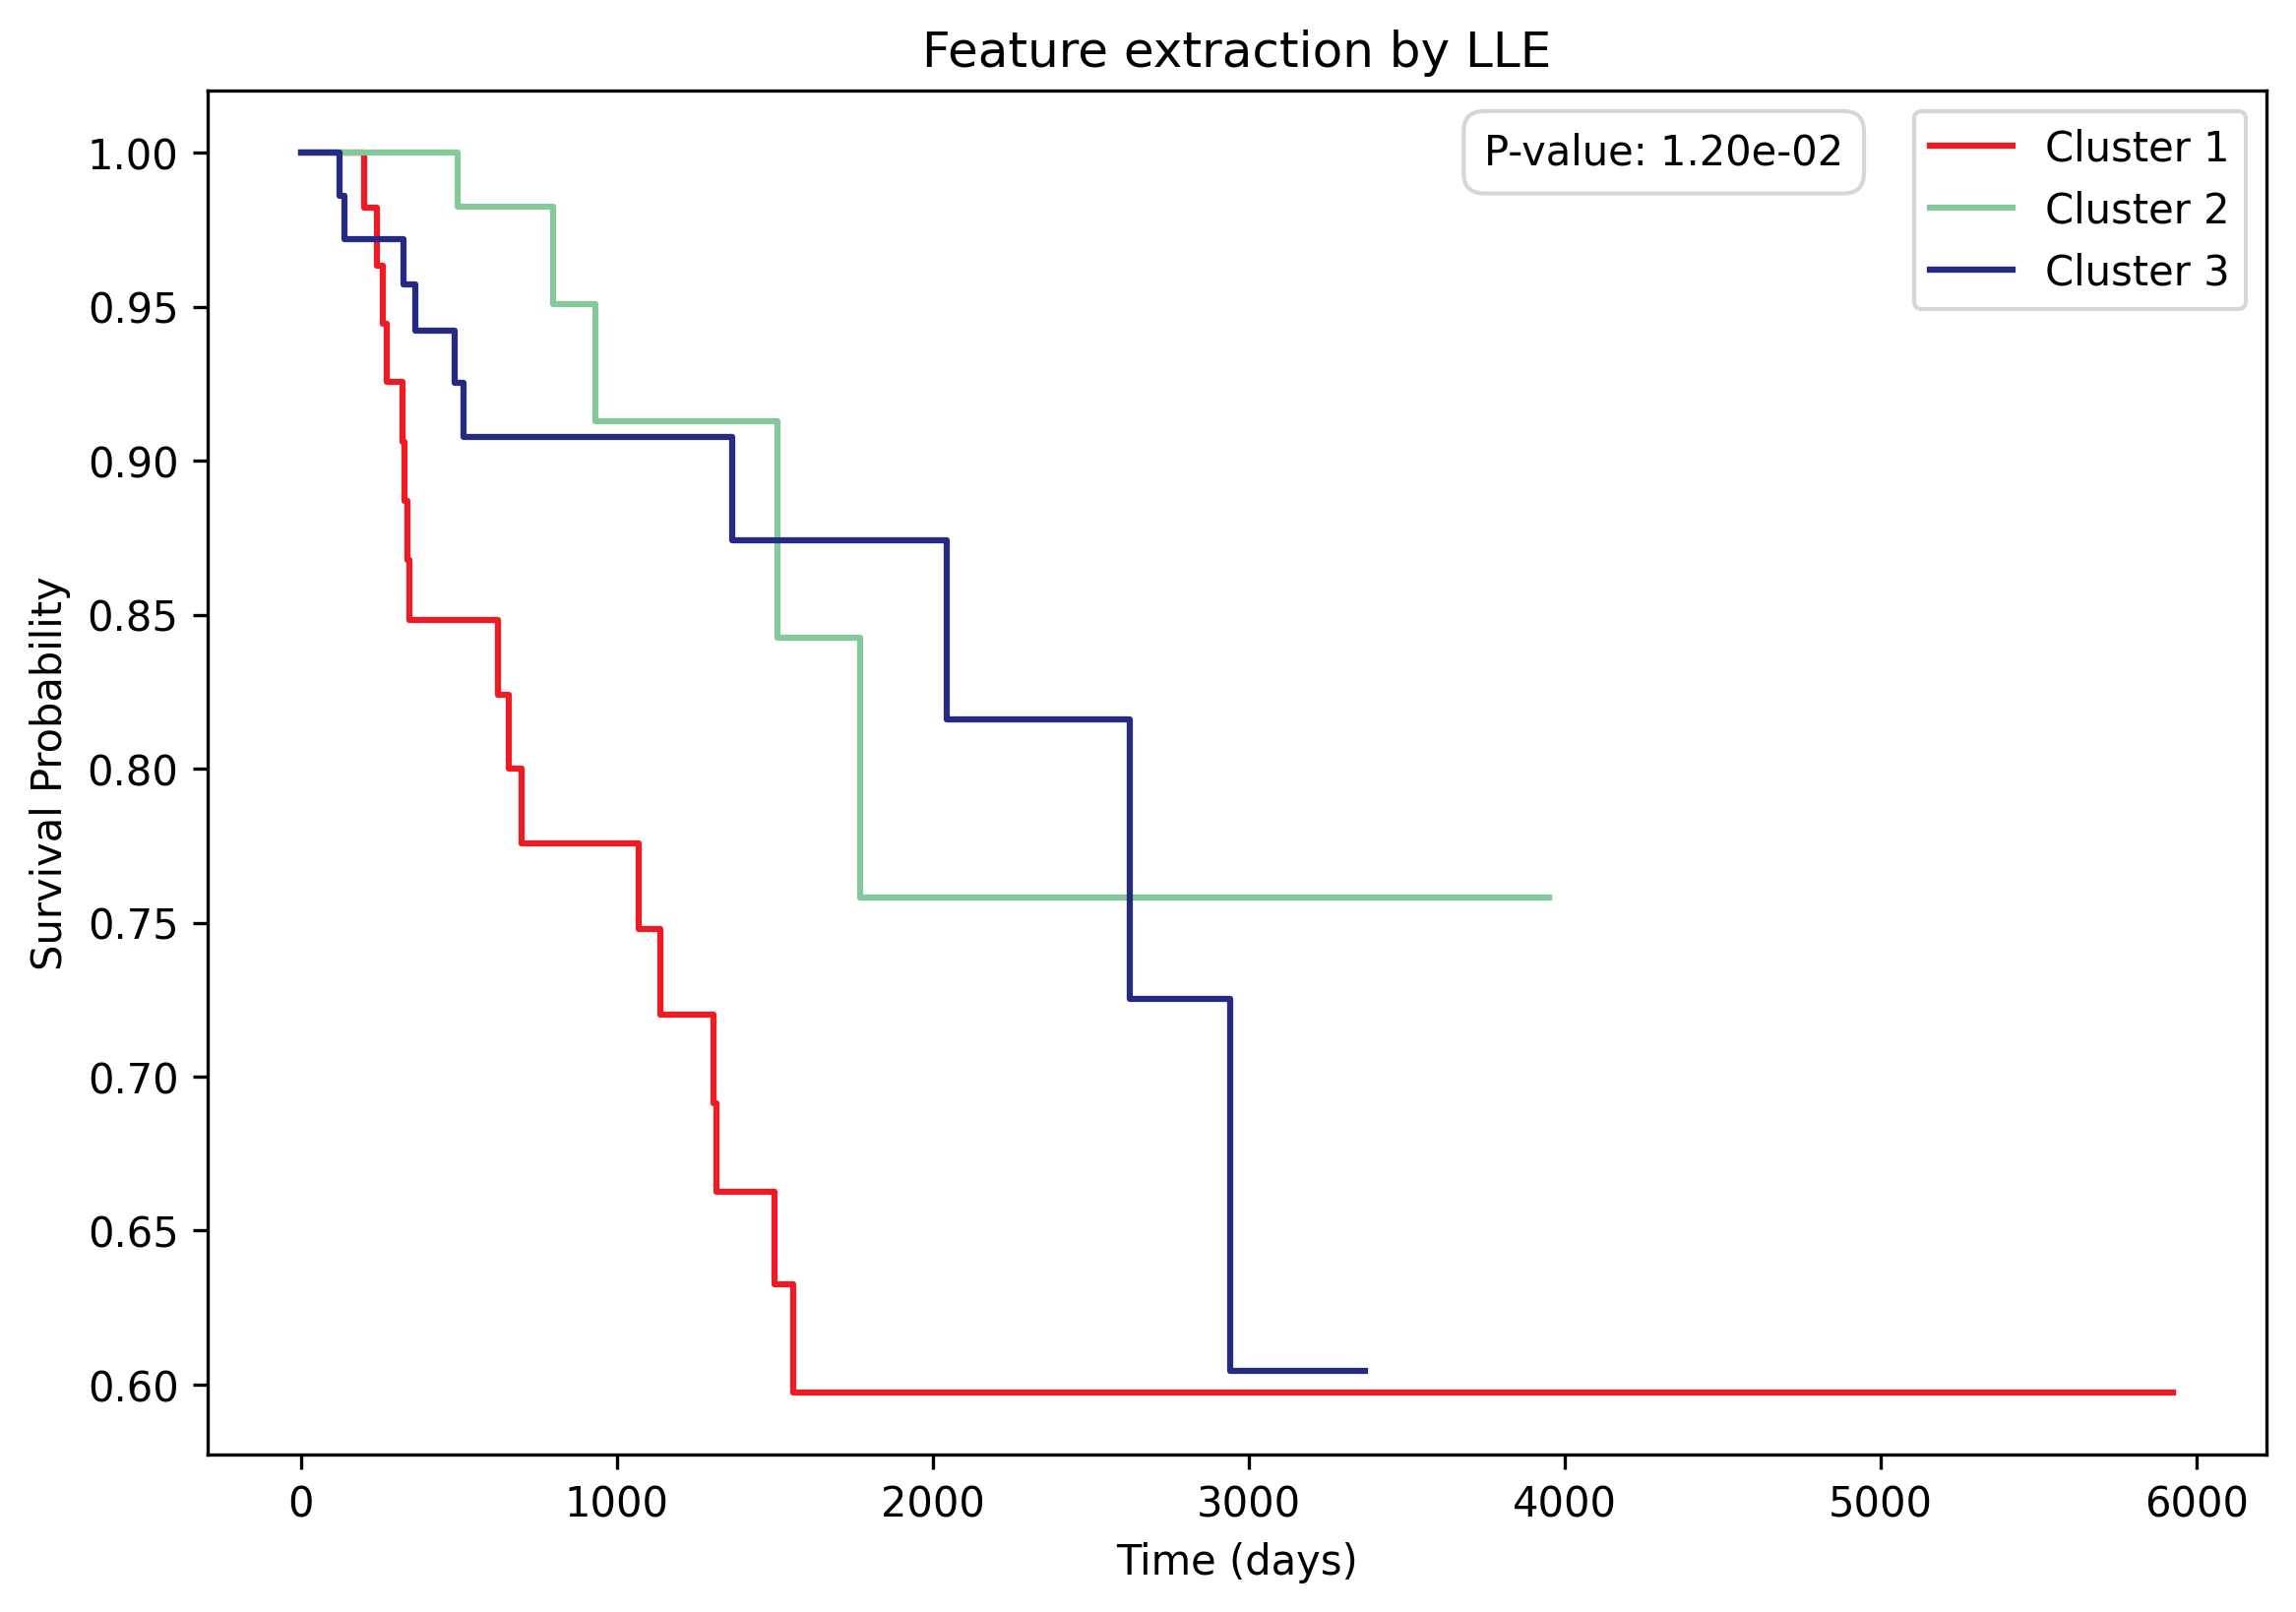

In [19]:
from sklearn.manifold import LocallyLinearEmbedding
mRNA_pca = LocallyLinearEmbedding(random_state=2).fit_transform(gene.values)
Methy_pca =LocallyLinearEmbedding(random_state=2).fit_transform(methy.values)
miRNA_pca = LocallyLinearEmbedding(random_state=2).fit_transform(mirna.values)

pandas2ri.activate()
umap = importr('umap')
cancersubtypes = importr('CancerSubtypes')


completed_data = np.concatenate([mRNA_pca[:, :3], Methy_pca[:, :3], miRNA_pca[:, :3]], axis=1)
U, _, _ = np.linalg.svd(completed_data)

U1 = U[:, :2]
clusters, similarities, number = spectral_clustering_nSNN(U1, 10)  
clusters2 = [map_cluster_to_color(cluster) for cluster in clusters]
clusters += 1

cluster_colors = {
    1: '#EE1B24',
    2: '#84C99A',
    3: '#252B84'
}
clusters2 = [cluster_colors[cluster] for cluster in clusters]

T = clinical['Time']
E = clinical['Death']
results = multivariate_logrank_test(T, clusters, E)
p_val_avg = results.p_value

all_shap = pandas2ri.DataFrame(pd.DataFrame(U1))
sil = cancersubtypes.silhouette_SimilarityMatrix(clusters, pandas2ri.DataFrame(pd.DataFrame(similar)))
umap_result = umap.umap(all_shap, n_neighbors=35, n_components=2, seed=123)

plt.figure(figsize=(9, 6), dpi=300)
for label, color in cluster_colors.items():
    plt.scatter([], [], color=color, label=f'Cluster {label}', s=15) 
plt.scatter(umap_result.rx2("layout")[:, 0], umap_result.rx2("layout")[:, 1], color=clusters2, s=15)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.title('Feature extraction by LLE')
plt.show()

plt.figure(figsize=(9, 6), dpi=300)
kmf = KaplanMeierFitter()
for label in set(clusters):
    mask = (clusters == label)
    kmf.fit(clinical['Time'][mask], event_observed=clinical['Death'][mask], label=f'Cluster {label}')
    kmf.plot(ci_show=False, color=cluster_colors[label])  
plt.text(0.62, 0.97, f'P-value: {format(p_val_avg, ".2e")}', 
         horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', edgecolor='#D6D6D6', boxstyle='round,pad=0.5'))
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.title('Feature extraction by LLE')
plt.show()

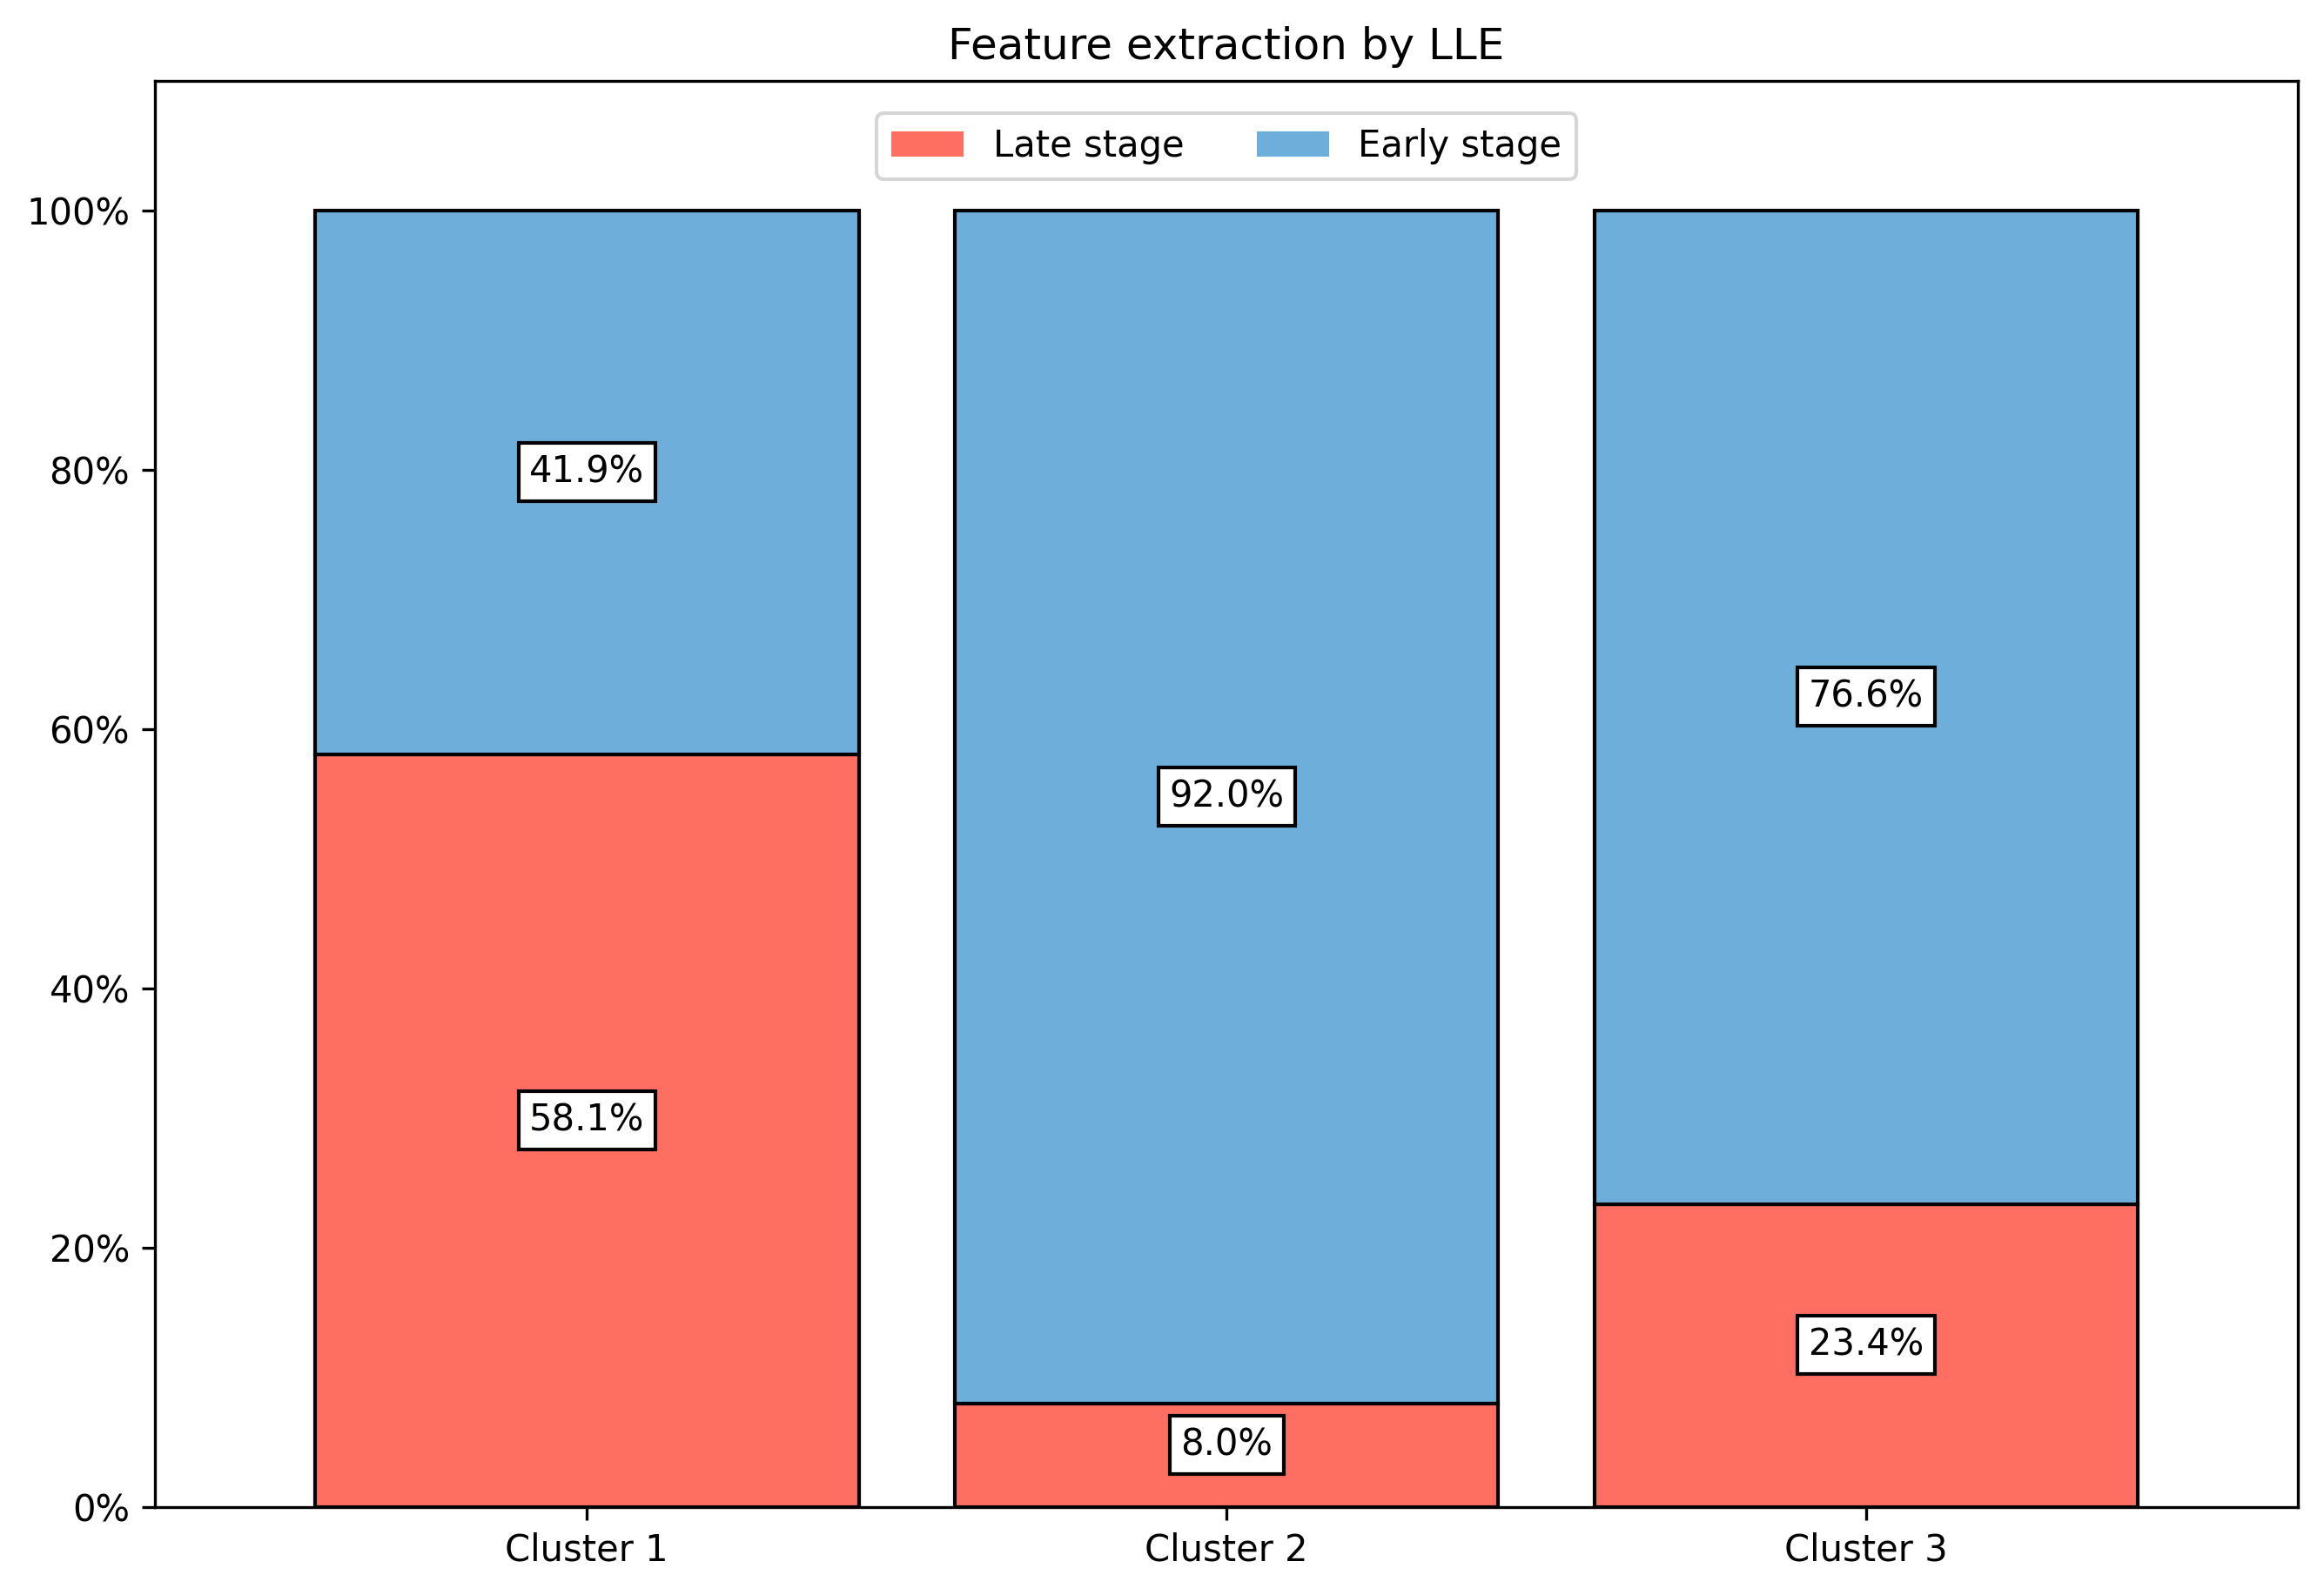

In [20]:
df_cnt_degs_norm = pd.DataFrame(U1)
df_cnt_degs_norm['cluster'] = clusters
df_cnt_degs_norm['label'] = pathoS

cluster_label_ratios = df_cnt_degs_norm.groupby(['cluster', 'label']).size().unstack(fill_value=0)
cluster_label_ratios = cluster_label_ratios.div(cluster_label_ratios.sum(axis=1), axis=0)
cluster_label_ratios = cluster_label_ratios.reindex(columns=[1.0, 0.0])

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
colors = {'label_1': '#6DAEDB', 'label_0': '#FF6F61'}


bar_width = 0.85
cluster_sample_counts = df_cnt_degs_norm['cluster'].value_counts().sort_index()
bars = cluster_label_ratios.plot(kind='bar', stacked=True, ax=ax, color=[colors[f'label_{i}'] for i in range(len(cluster_label_ratios.columns))], width=bar_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(range(len(cluster_sample_counts)), [f'Cluster {i + 1}' for i in range(len(cluster_sample_counts))], rotation=0)

plt.legend(labels=['Late stage', 'Early stage'],  bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=2)

for i, count in enumerate(cluster_sample_counts):
    #ax.text(i, -0.08, f'(n={count})', ha='center')  
    total_height = 0
    for j in range(len(cluster_label_ratios.columns)):
        label_ratio = cluster_label_ratios.iloc[i, j]
        if label_ratio != 0:  
            ax.text(i, total_height + label_ratio / 2, f'{label_ratio:.1%}', ha='center', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=3))
        total_height += label_ratio

for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.title('Feature extraction by LLE')
plt.show()


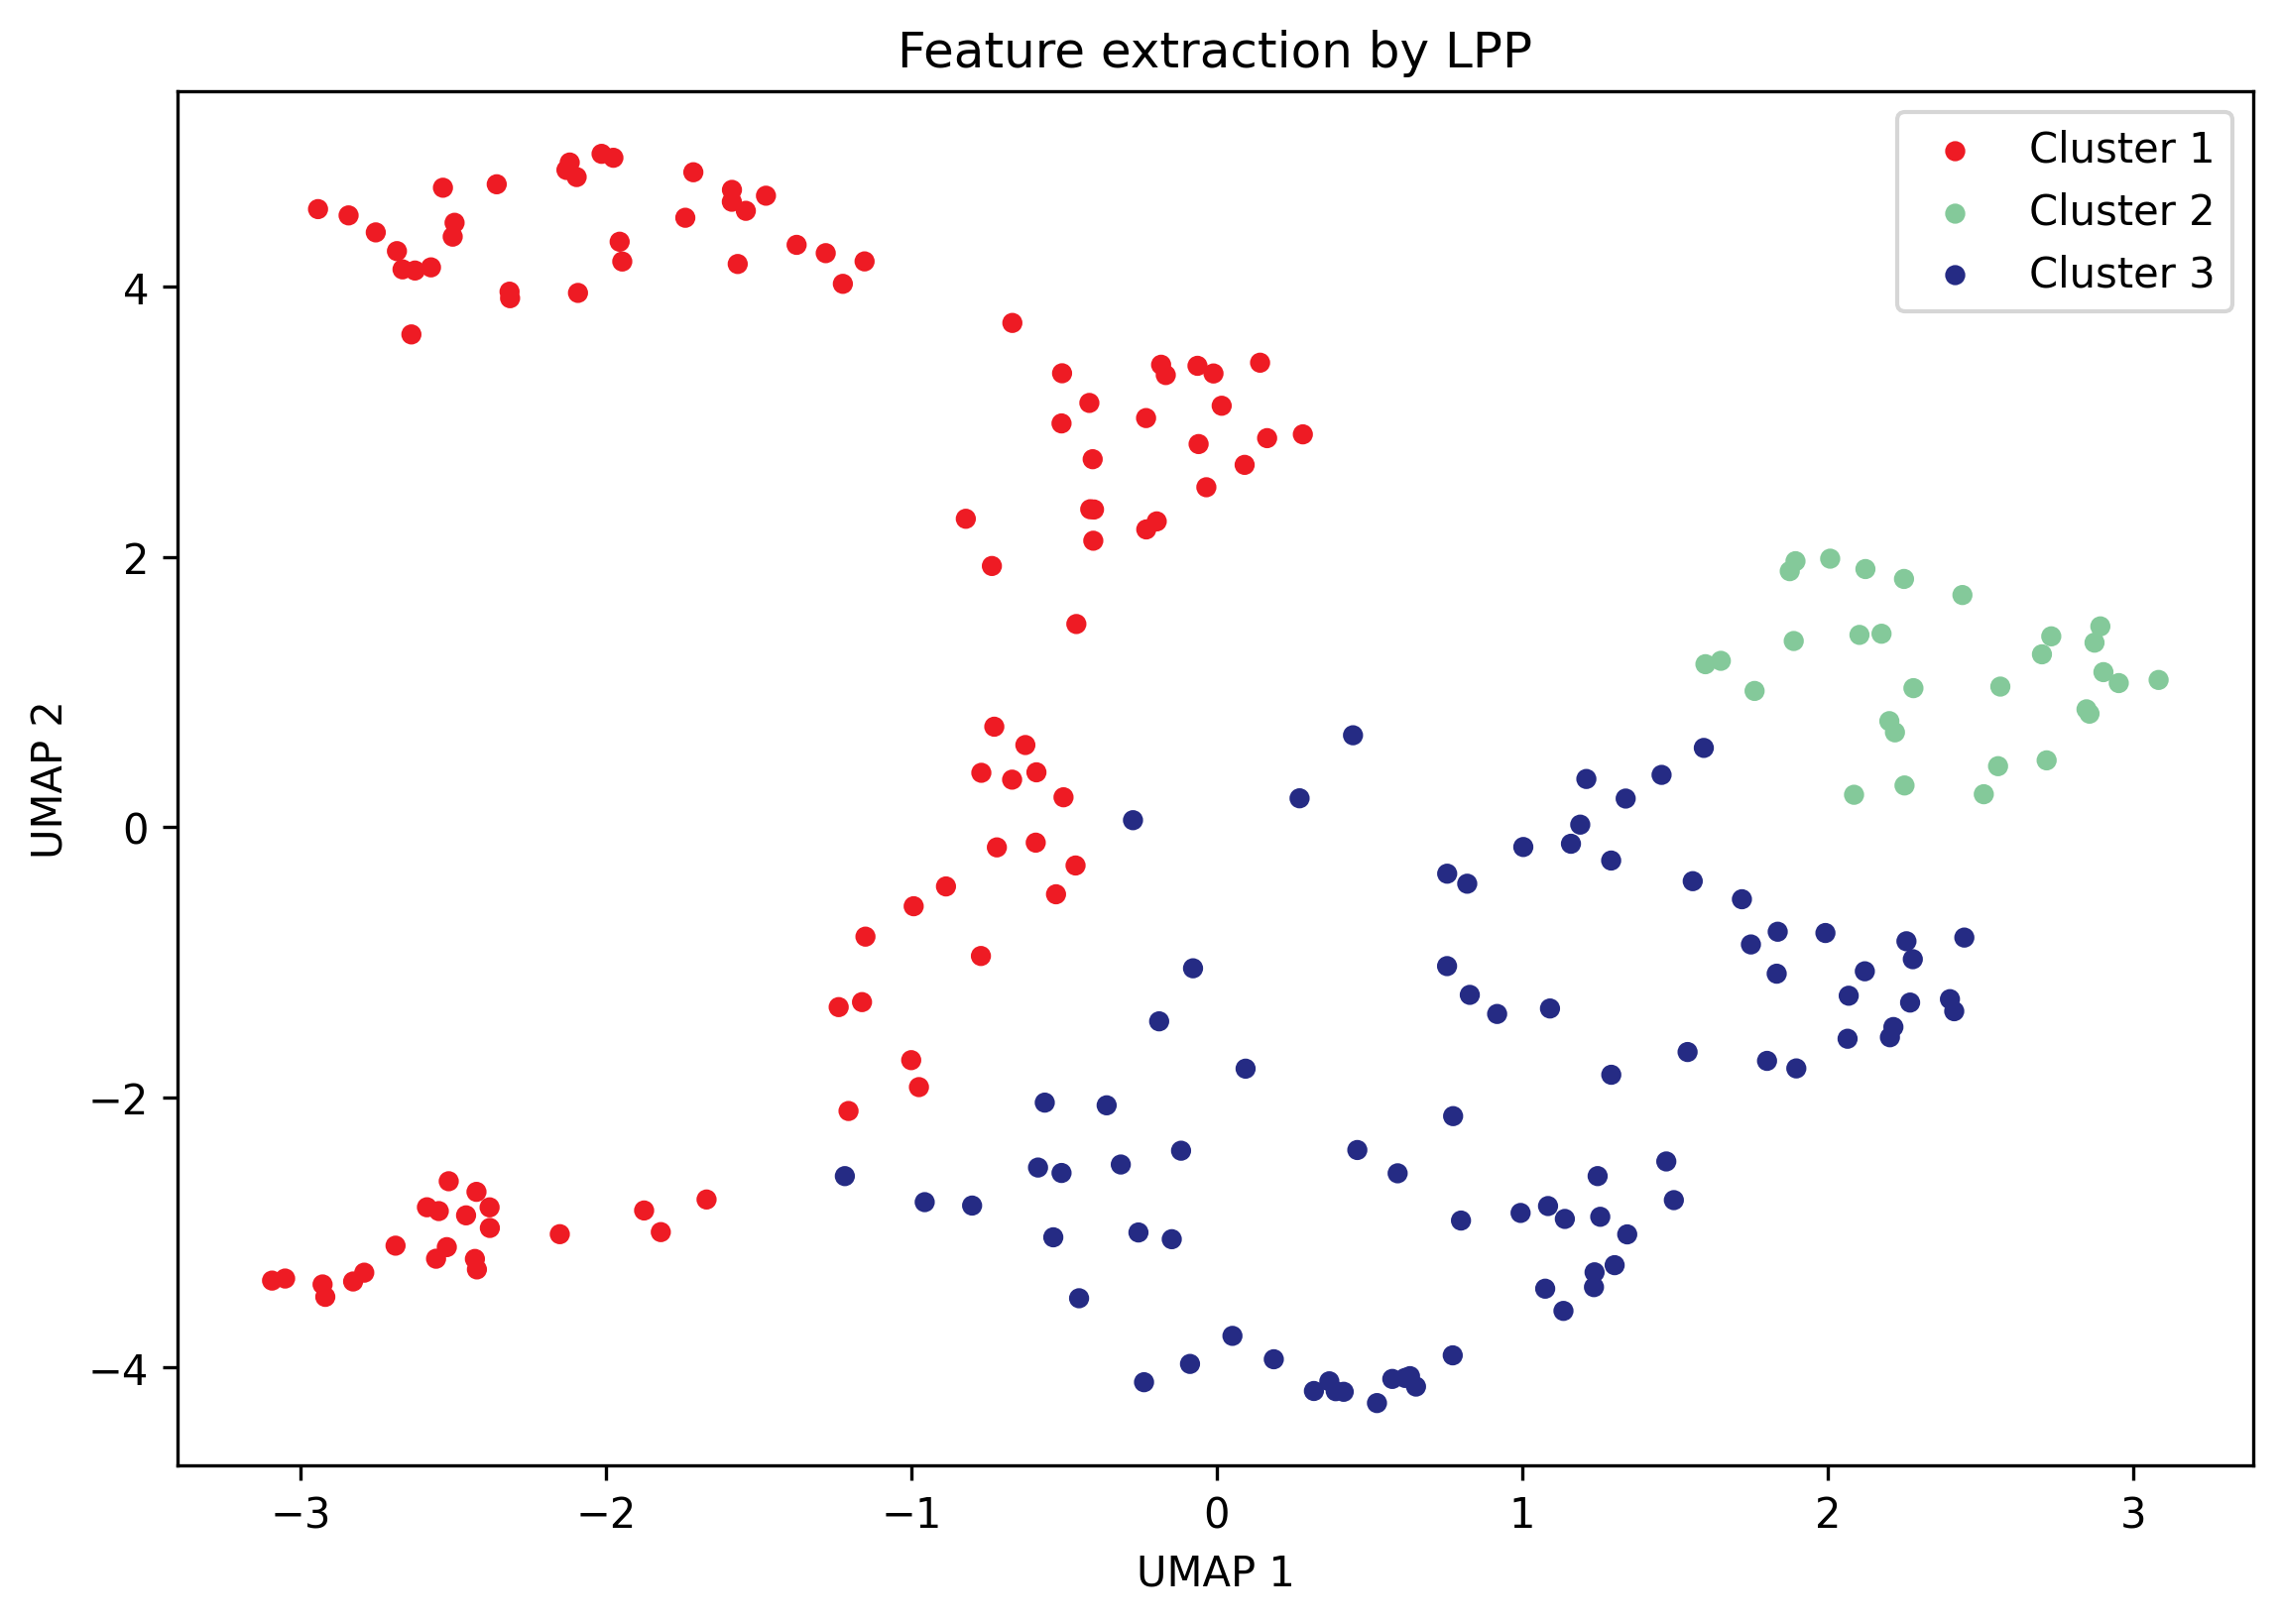

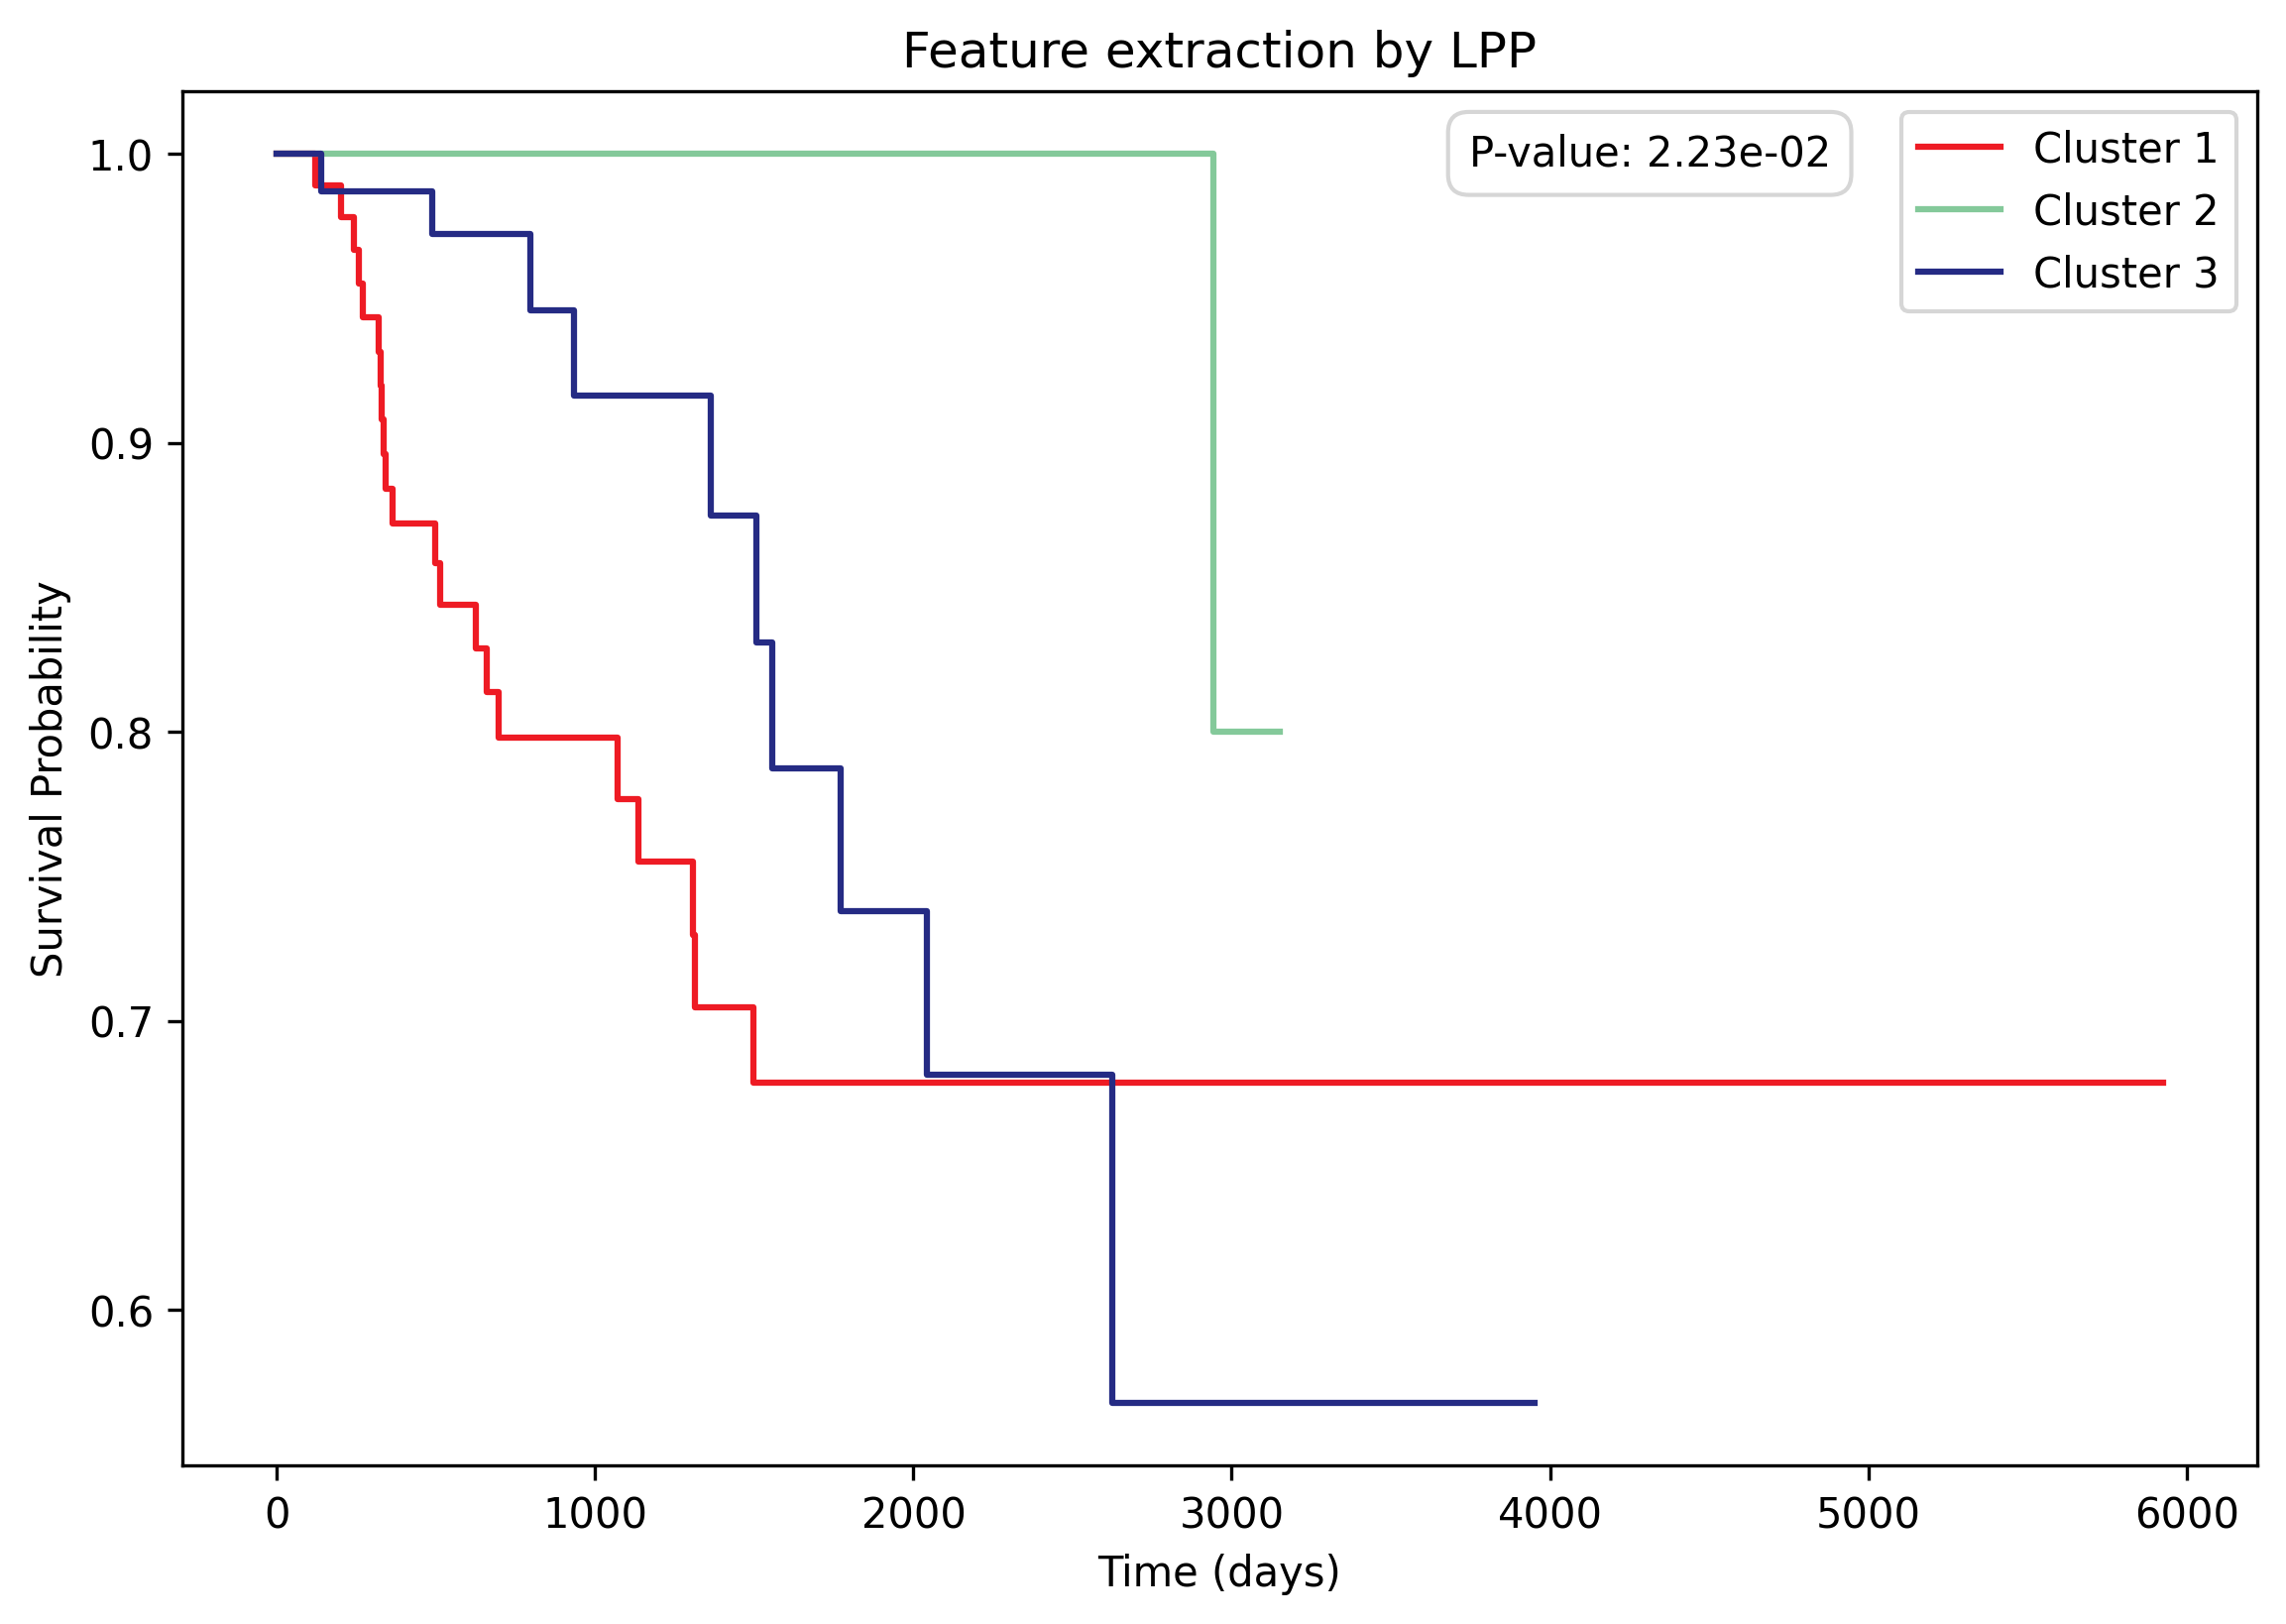

In [30]:
from lpproj import LocalityPreservingProjection 
mRNA_pca = LocalityPreservingProjection().fit_transform(gene.values)
Methy_pca =LocalityPreservingProjection().fit_transform(methy.values)
miRNA_pca = LocalityPreservingProjection().fit_transform(mirna.values)


completed_data = np.concatenate([mRNA_pca[:, :3], Methy_pca[:, :3], miRNA_pca[:, :3]], axis=1)
U, _, _ = np.linalg.svd(completed_data)

U1 = U[:, :2]
      
clusters, similarities, number = spectral_clustering_nSNN(U1, 4)  
clusters2 = [map_cluster_to_color(cluster) for cluster in clusters]

clusters += 1

cluster_colors = {
    1: '#EE1B24',
    2: '#84C99A',
    3: '#252B84'
}
clusters2 = [cluster_colors[cluster] for cluster in clusters]

T = clinical['Time']
E = clinical['Death']
results = multivariate_logrank_test(T, clusters, E)
p_val_avg = results.p_value

all_shap = pandas2ri.DataFrame(pd.DataFrame(U1))
sil = cancersubtypes.silhouette_SimilarityMatrix(clusters, pandas2ri.DataFrame(pd.DataFrame(similar)))
umap_result = umap.umap(all_shap, n_neighbors=35, n_components=2, seed=123)

plt.figure(figsize=(9, 6), dpi=300)
for label, color in cluster_colors.items():
    plt.scatter([], [], color=color, label=f'Cluster {label}', s=15)  
plt.scatter(umap_result.rx2("layout")[:, 0], umap_result.rx2("layout")[:, 1], color=clusters2, s=15)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.title('Feature extraction by LPP')
plt.show()

plt.figure(figsize=(9, 6), dpi=300)
kmf = KaplanMeierFitter()
for label in set(clusters):
    mask = (clusters == label)
    kmf.fit(clinical['Time'][mask], event_observed=clinical['Death'][mask], label=f'Cluster {label}')
    kmf.plot(ci_show=False, color=cluster_colors[label]) 
plt.text(0.62, 0.97, f'P-value: {format(p_val_avg, ".2e")}', 
         horizontalalignment='left', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', edgecolor='#D6D6D6', boxstyle='round,pad=0.5'))
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.title('Feature extraction by LPP')
plt.show()

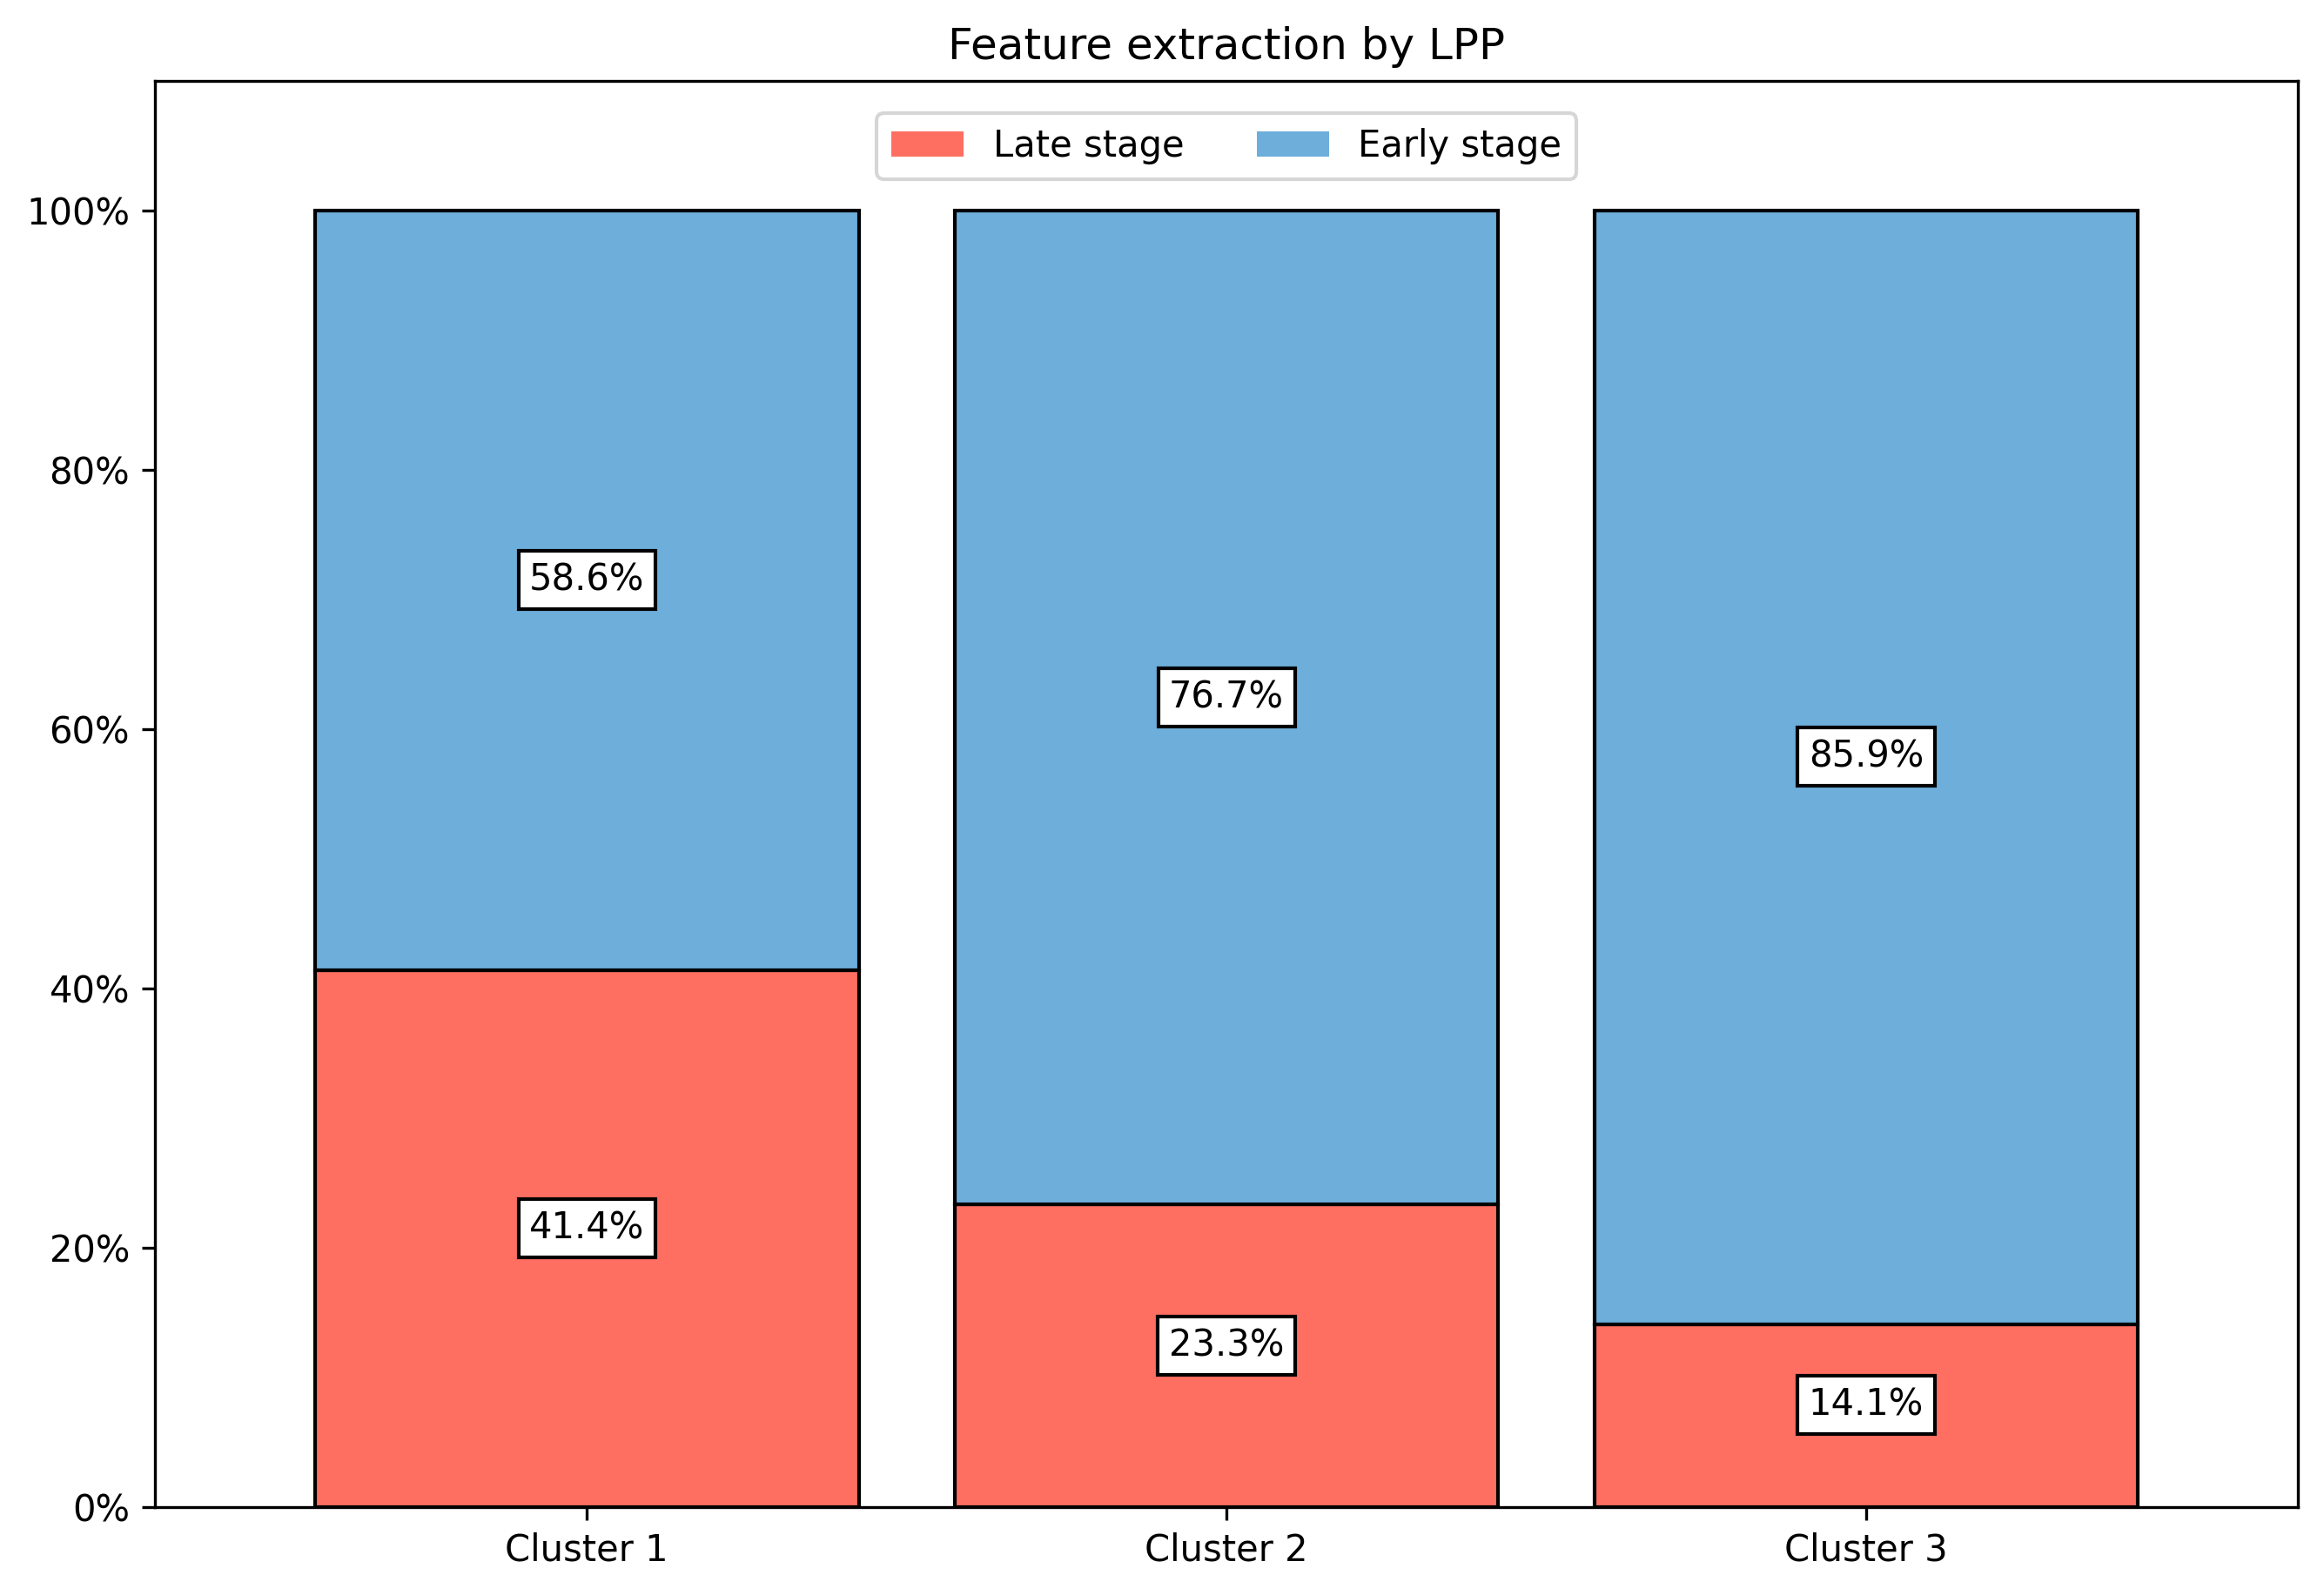

In [31]:
df_cnt_degs_norm = pd.DataFrame(U1)
df_cnt_degs_norm['cluster'] = clusters
df_cnt_degs_norm['label'] = pathoS

cluster_label_ratios = df_cnt_degs_norm.groupby(['cluster', 'label']).size().unstack(fill_value=0)
cluster_label_ratios = cluster_label_ratios.div(cluster_label_ratios.sum(axis=1), axis=0)
cluster_label_ratios = cluster_label_ratios.reindex(columns=[1.0, 0.0])

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
colors = {'label_1': '#6DAEDB', 'label_0': '#FF6F61'}

bar_width = 0.85
cluster_sample_counts = df_cnt_degs_norm['cluster'].value_counts().sort_index()
bars = cluster_label_ratios.plot(kind='bar', stacked=True, ax=ax, color=[colors[f'label_{i}'] for i in range(len(cluster_label_ratios.columns))], width=bar_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(range(len(cluster_sample_counts)), [f'Cluster {i + 1}' for i in range(len(cluster_sample_counts))], rotation=0)

plt.legend(labels=['Late stage', 'Early stage'],  bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=2)

for i, count in enumerate(cluster_sample_counts):
    #ax.text(i, -0.08, f'(n={count})', ha='center')  
    total_height = 0
    for j in range(len(cluster_label_ratios.columns)):
        label_ratio = cluster_label_ratios.iloc[i, j]
        if label_ratio != 0:  
            ax.text(i, total_height + label_ratio / 2, f'{label_ratio:.1%}', ha='center', color='black', bbox=dict(facecolor='white', edgecolor='black', pad=3))
        total_height += label_ratio

for bar in bars.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.title('Feature extraction by LPP')
plt.show()
